In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx
import scipy.spatial
import torch
import skimage.draw
from scipy.spatial import Delaunay 

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.seacast_tools.mesh_models.mesh_metrics as mm

In [4]:
def crosses_land(node1, node2, land_mask, threshold=8):
    x1, y1 = node1
    x2, y2 = node2
    rr, cc = skimage.draw.line(round(y1), round(x1), round(y2), round(x2))
    return np.sum(land_mask[rr, cc]) >= threshold

def add_diagonal_edges(nx, ny, g):
    """
    Add diagonal edges to a grid graph, where the graph neeeds to be a square uniform grid.
    The function iterates over the nodes in the grid and adds edges between diagonal nodes.

    Params:
    nx: number of nodes in x direction
    ny: number of nodes in y direction
    g: networkx graph object to which the diagonal edges will be added
    """
    for x in range(nx - 1):
        for y in range(ny - 1):
            if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
                g.add_edge((x, y), (x + 1, y + 1))
            if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
                g.add_edge((x + 1, y), (x, y + 1))

def add_Delaunay_edges(g):
    g.remove_edges_from(list(g.edges()))
    
    nodes_list = list(g.nodes())
    points = np.array([g.nodes[node]["pos"] for node in nodes_list])
    
    tri = scipy.spatial.Delaunay(points)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes_list[simplex[i]]
                node2 = nodes_list[simplex[j]]
                if g.has_node(node1) and g.has_node(node2):
                    g.add_edge(node1, node2)


def generate_random_nodes_positions(nx, ny, xm, xM, ym, yM):
    """ 
    Generate random nodes positions inside the mesh

    returns = list of coordinates (x,y) of the nodes to create a Graph with networkx
    """
    N = nx * ny
    lx = np.random.uniform(xm, xM, N)
    ly = np.random.uniform(ym, yM, N)
    secure_positions_within_the_limit(xm, xM, ym, yM, (xM - xm) / nx, (yM - ym) / ny, lx, ly)
    list_coords = []
    for x, y in zip(lx, ly):
        coord = (x, y)
        list_coords.append(coord)
    return list_coords



def generate_mesh_positions_with_random_offsets(nx, ny, lower_offset_bound, upper_offset_bound, xm, xM, ym, yM):
    dx = (xM - xm) / nx
    dy = (yM - ym) / ny
    lx = np.linspace(xm + dx / 2, xM - dx / 2, nx, dtype=np.float32)
    ly = np.linspace(ym + dy / 2, yM - dy / 2, ny, dtype=np.float32)


    random_offset_x = np.random.uniform(lower_offset_bound, upper_offset_bound, len(lx))
    random_offset_y = np.random.uniform(lower_offset_bound, upper_offset_bound, len(ly))

    lx = lx + random_offset_x
    ly = ly + random_offset_y
    
    secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly)
    return lx,ly

def secure_positions_within_the_limit(xm, xM, ym, yM, dx, dy, lx, ly):
    lx[0] = xm + dx / 2
    lx[-1] = xM - dx / 2

    for i in range(len(lx)):    
        if lx[i] < xm + dx / 2:
            lx[i] = xm + dx / 2
        if lx[i] > xM - dx / 2:
            lx[i] = xM - dx / 2
    
    ly[0] = ym + dy / 2
    ly[-1] = yM - dy / 2

    for i in range(len(ly)):
        if ly[i] < ym + dy / 2:
            ly[i] = ym + dy / 2
        if ly[i] > yM - dy / 2:
            ly[i] = yM - dy / 2

In [5]:
def generate_basic_probability_distribution(bathymetry):
    epsilon = 1e-3
    # If bathymetry is 0, we set density to 0.0, otherwise we set it to 1.0/(bathymetry + epsilon)
    # with the inverse, we try to give more "importance" to the shallow areas (where bathymetry is small)
    # We add epsilon to avoid division by zero and to ensure that the density is not infinite as a safeguard.
    density = np.where(bathymetry > 0, 1.0 / (bathymetry + epsilon), 0)
    p = density / np.sum(density)  # Normalizar para obtener distribución de probabilidad
    return p

In [2]:
def generate_sigmoid_probability_distribution(bathymetry, median_percentile= 25):
    """
    Genera una matriz de probabilidades a partir de la batimetría utilizando una función sigmoidea, 
    calculando automáticamente el punto de inflexión (mediana) y la pendiente (IQR) a partir de los 
    valores correspondientes al mar (bathymetry > 0). Los valores de tierra (bathymetry == 0) se excluyen 
    y se asigna probabilidad 0.
    
    Parámetros:
        bathymetry: array 2D con valores de profundidad, donde 0 representa tierra y valores > 0 mar.
        
    Retorna:
        p: array 2D con la misma forma que 'bathymetry' que contiene la distribución de probabilidad 
           normalizada, considerando únicamente los valores del mar.
    """
    # Crear una máscara para los valores del mar (bathymetry > 0)
    valid = bathymetry > 0
    if not np.any(valid):
        raise ValueError("No hay valores de mar (bathymetry > 0) para calcular la probabilidad.")
    
    # Extraer únicamente los valores válidos (del mar)
    valid_values = bathymetry[valid]
    
    # Calcular la mediana y el rango intercuartílico (IQR) a partir de los valores válidos
    mediana = np.percentile(valid_values, median_percentile)
    q75, q25 = np.percentile(valid_values, [75, 25])
    iqr = q75 - q25
    if iqr == 0:
        iqr = 1e-3  # Evita división por cero en caso de muy poca variabilidad
    
    # Aplicar la función sigmoidea: zonas con batimetría menor a la mediana (más someras)
    # tendrán valores altos, y las zonas profundas recibirán valores bajos.
    p_valid = 1.0 / (1.0 + np.exp((valid_values - mediana) / iqr))
    
    # Crear una matriz de probabilidades con la misma forma que bathymetry, asignando 0 a tierra
    p_all = np.zeros(bathymetry.shape)
    p_all[valid] = p_valid

    # Normalizar solo los valores correspondientes al mar para que la suma total sea 1
    p_all /= p_all.sum()
    
    return p_all


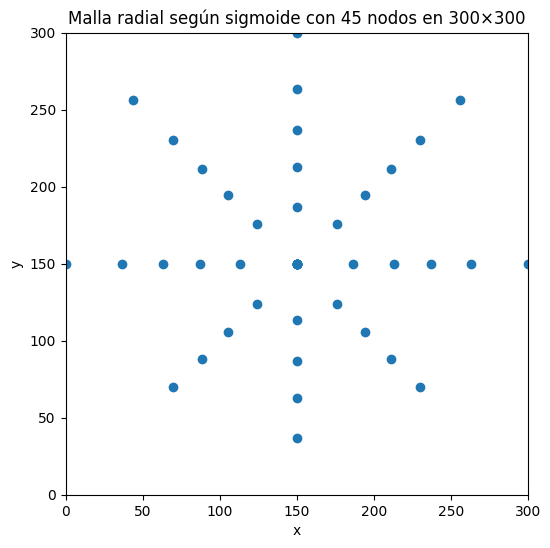

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_grid(a, b, N):
    # 1) puntos uniformes en (0,1)
    u = np.linspace(1/(N+1), N/(N+1), N)
    # 2) logit
    z = np.log(u / (1 - u))
    # 3) normalizar a [a,b]
    z_min, z_max = z.min(), z.max()
    return a + (z - z_min) / (z_max - z_min) * (b - a)

def radial_sigmoid_fixed(res_x, res_y, N_total):
    # Centro y radio máximo para ajustarse a la resolución
    cx, cy = res_x / 2, res_y / 2
    R = min(res_x, res_y) / 2
    # Elegimos números de anillos y por anillo para aproximar N_total
    N_rings = int(np.floor(np.sqrt(N_total)))
    N_per_ring = int(np.ceil(N_total / N_rings))
    # Radios según logit
    radii = logistic_grid(0, R, N_rings)
    thetas = np.linspace(0, 2*np.pi, N_per_ring, endpoint=False)
    pts = []
    for r in radii:
        for theta in thetas:
            x = cx + r * np.cos(theta)
            y = cy + r * np.sin(theta)
            pts.append((x, y))
    pts = np.array(pts)[:N_total]  # truncamos para quedarnos con N_total exactos
    return pts

# Parámetros de demostración
res_x, res_y = 300, 300
N_total = 45
points = radial_sigmoid_fixed(res_x, res_y, N_total)

# Gráfico
plt.figure(figsize=(6,6))
plt.scatter(points[:, 0], points[:, 1])
plt.gca().set_aspect('equal', 'box')
plt.xlim(0, res_x)
plt.ylim(0, res_y)
plt.xticks(np.arange(0, res_x+1, 50))
plt.yticks(np.arange(0, res_y+1, 50))
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Malla radial según sigmoide con {N_total} nodos en {res_x}×{res_y}')
plt.show()


In [6]:
def generate_mixed_distribution(bathymetry, alpha=0.7):
    valid = bathymetry > 0
    if not np.any(valid):
        raise ValueError("No ocean values found.")
    # sigmoid with preference for shallow areas
    p_sig_coast = generate_sigmoid_probability_distribution(bathymetry, median_percentile = 25)
    # sigmoid with preference with no preference for neither shallow or deep areas
    p_sig_deep = generate_sigmoid_probability_distribution(bathymetry, median_percentile = 50)#75 for deep areas
    # mix and normalize
    p_mix = alpha * p_sig_coast + (1 - alpha) * p_sig_deep
    p_mix /= p_mix.sum()
    return p_mix


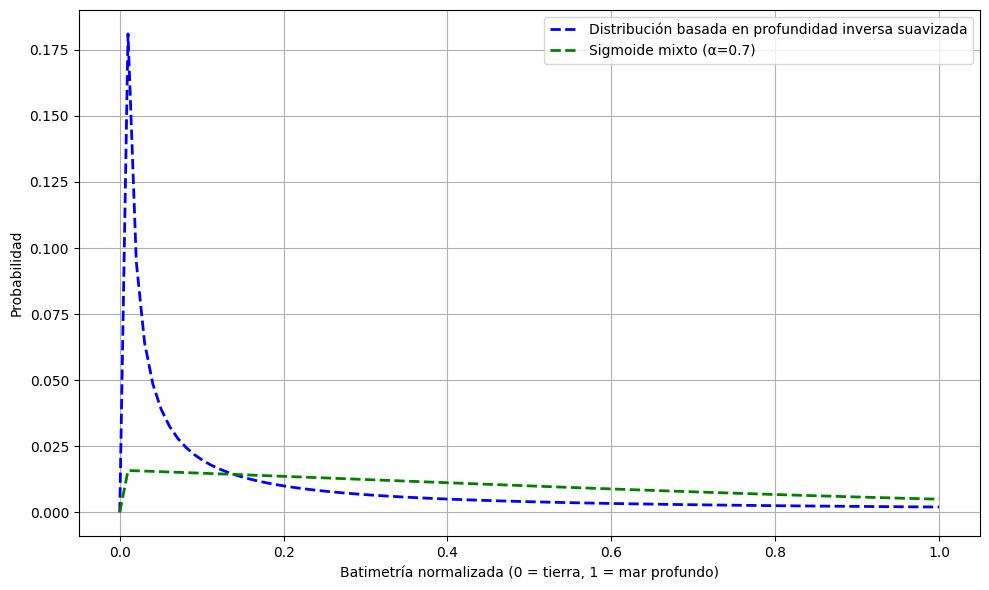

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Generar valores de batimetría normalizados de 0 a 1
bathy_values = np.linspace(0, 1, 100).reshape((10, 10))

# Calcular distribuciones
p_basic = generate_basic_probability_distribution(bathy_values).flatten()
p_mix = generate_mixed_distribution(bathy_values, alpha=0.7).flatten()

# Aplanar los valores de batimetría correspondientes
bathy_flat = bathy_values.flatten()

# Ordenar para visualizar correctamente las curvas
sorted_idx = np.argsort(bathy_flat)
bathy_sorted = bathy_flat[sorted_idx]
p_basic_sorted = p_basic[sorted_idx]
p_mix_sorted = p_mix[sorted_idx]

# Graficar las curvas
plt.figure(figsize=(10, 6))
plt.plot(bathy_sorted, p_basic_sorted, label="Distribución basada en profundidad inversa suavizada", color="blue", linewidth=2, linestyle='--')
plt.plot(bathy_sorted, p_mix_sorted, label="Sigmoide mixto (α=0.7)", color="green", linewidth=2, linestyle='--')
#plt.title("Curvature of Probability Distributions vs. Normalized Bathymetry")
plt.xlabel("Batimetría normalizada (0 = tierra, 1 = mar profundo)")
plt.ylabel("Probabilidad")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("distribuciones_probabilidad.pdf", format='pdf')
plt.show()


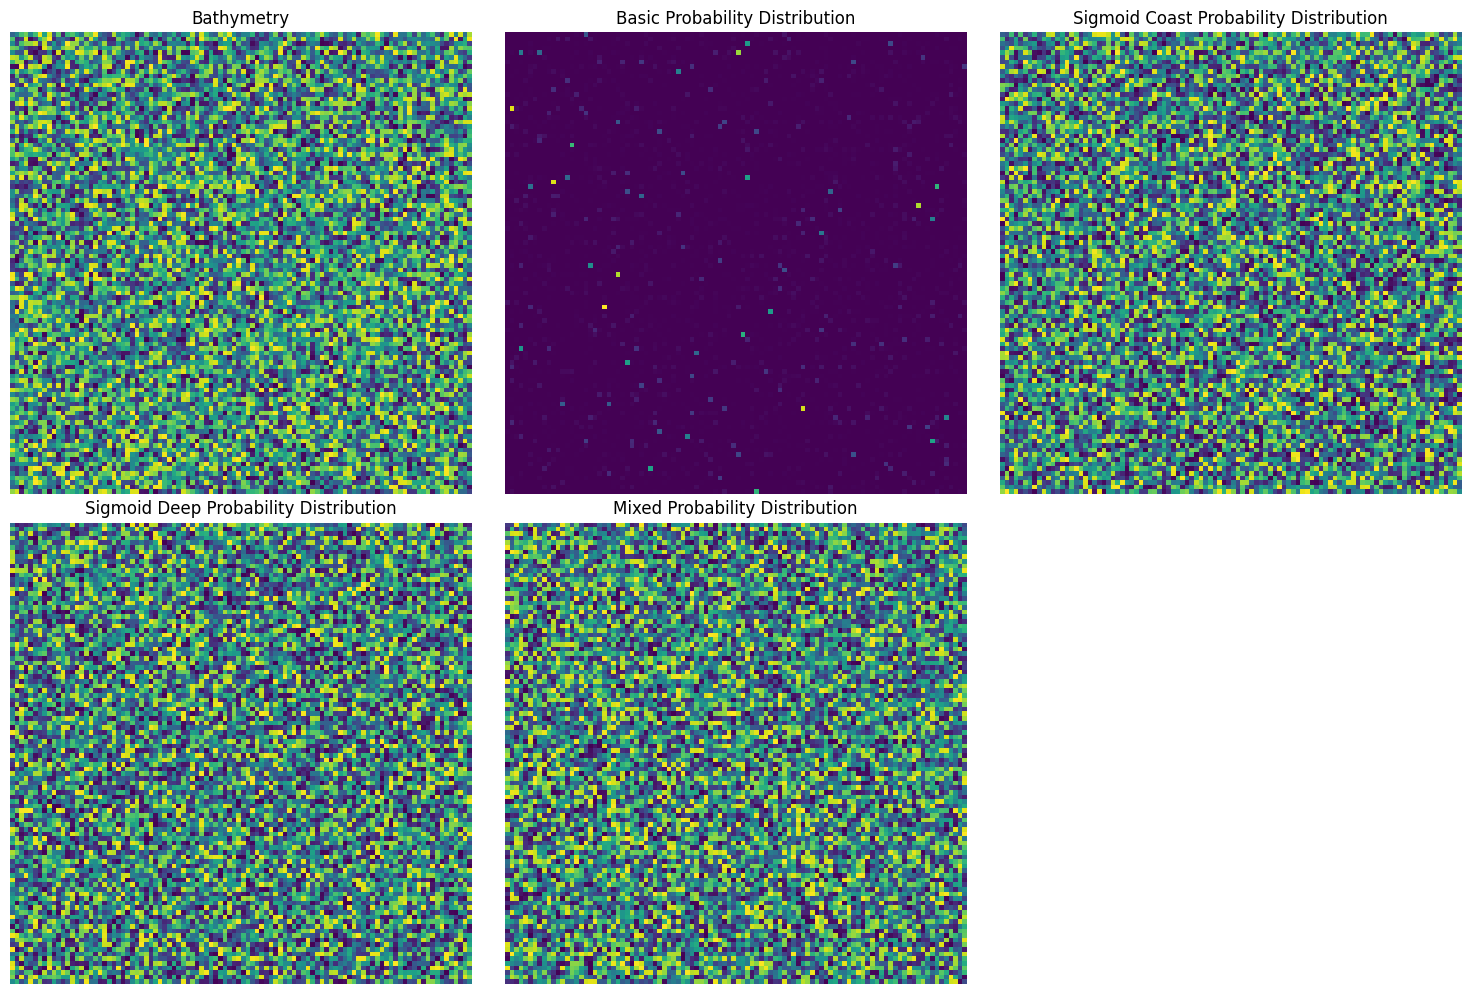

In [7]:
import numpy as np

def sample_nodes_with_corners(p_mix, num_nodes, corner_size=(10, 10), random_state=None):
    """
    Muestrea nodos asegurando al menos 1 en cada esquina de la matriz de probabilidades.

    Parámetros:
        p_mix: array 2D con la distribución de probabilidad (sum = 1).
        num_nodes: número total de nodos a muestrear.
        corner_size: tupla (alto, ancho) de la ventana de esquina en número de celdas.
        random_state: semilla para reproducibilidad.

    Retorna:
        coords: lista de tuplas (i, j) con las coordenadas de los nodos muestreados.
    """
    rng = np.random.default_rng(random_state)
    H, W = p_mix.shape
    # Define máscaras de cada esquina
    h_cs, w_cs = corner_size
    corners = {
        "top_left":    (slice(0, h_cs),        slice(0, w_cs)),
        "top_right":   (slice(0, h_cs),        slice(W-w_cs, W)),
        "bottom_left": (slice(H-h_cs, H),      slice(0, w_cs)),
        "bottom_right":(slice(H-h_cs, H),      slice(W-w_cs, W)),
    }

    selected = set()
    # 1) Extraer 1 nodo de cada esquina si hay probabilidad
    for corner, (rs, cs) in corners.items():
        subp = p_mix[rs, cs]
        total = subp.sum()
        if total > 0:
            # prob. normalizada dentro de la esquina
            flat = (subp / total).ravel()
            idx = rng.choice(flat.size, p=flat)
            # reconvertir a coordenadas globales
            i_local, j_local = divmod(idx, subp.shape[1])
            i = rs.start + i_local
            j = cs.start + j_local
            selected.add((i, j))

    # 2) Muestrear el resto sin volver a elegir las mismas celdas
    remaining = num_nodes - len(selected)
    if remaining > 0:
        # aplanar p_mix y hacer cero las posiciones ya seleccionadas
        flat_p = p_mix.ravel().copy()
        for (i,j) in selected:
            flat_p[i * W + j] = 0
        total = flat_p.sum()
        if total == 0:
            raise ValueError("No quedan celdas válidas para muestrear el resto.")
        flat_p /= total
        # elegir 'remaining' índices sin reemplazo
        idxs = rng.choice(flat_p.size, size=remaining, replace=False, p=flat_p)
        for idx in idxs:
            i, j = divmod(idx, W)
            selected.add((i, j))

    return list(selected)


# Ejemplo de uso completo:
def generate_and_sample(bathymetry, num_nodes, alpha=0.7, corner_size=(10,10)):
    # 1) Generar la mezcla de sigmoides
    p_mix = generate_mixed_distribution(bathymetry, alpha=alpha)
    # 2) Muestrear nodos con esquinas garantizadas
    coords = sample_nodes_with_corners(p_mix, num_nodes, corner_size=corner_size)
    return coords


In [8]:
def get_ocean_corners(mask, inverted=False):
    """
    Para una máscara 2D booleana, devuelve las 4 esquinas del área de océano.
    
    Parámetros:
      mask      — array 2D booleano
      inverted  — si True, interpreta mask==False como océano (y True como tierra)
    """
    # Ajusto la máscara para que 'ocean_mask' sea True donde haya mar
    ocean_mask = (~mask) if inverted else mask
    
    # Índices de todas las celdas de mar
    rows, cols = np.where(ocean_mask)
    if rows.size == 0:
        raise ValueError("La máscara no contiene ningún punto de océano")
    
    # Bounding‑box del océano
    min_r, max_r = rows.min(), rows.max()
    min_c, max_c = cols.min(), cols.max()
    targets = {
        'bottom_left':  (min_r, min_c),
        'bottom_right': (min_r, max_c),
        'top_left':     (max_r, min_c),
        'top_right':    (max_r, max_c),
    }
    
    # Para cada vértice del bounding‑box, busca el True más cercano
    nearest = {}
    for name, (tr, tc) in targets.items():
        # calcula distancia al cuadrado a cada punto de mar
        d2 = (rows - tr)**2 + (cols - tc)**2
        idx = np.argmin(d2)
        nearest[name] = (rows[idx], cols[idx])
    return nearest

In [9]:
# -------------------------------
# Función para filtrar nodos cercanos (radio mínimo)
def enforce_minimum_distance(points, min_radius):
    """
    Filtra los puntos candidatos para asegurar que ninguno esté a una distancia menor a min_radius de otro.
    
    Args:
        points (np.ndarray): Array de puntos candidatos de forma (n, 2).
        min_radius (float): Distancia mínima permitida entre puntos.
        
    Returns:
        np.ndarray: Array de puntos aceptados.
    """
    accepted = []
    # Procesa los puntos en orden aleatorio
    indices = np.random.permutation(len(points))
    for idx in indices:
        pt = points[idx]
        if len(accepted) == 0:
            accepted.append(pt)
        else:
            accepted_arr = np.array(accepted)
            # Verifica que la distancia de pt a cada punto aceptado sea >= min_radius
            if np.all(np.linalg.norm(accepted_arr - pt, axis=1) >= min_radius):
                accepted.append(pt)
    return np.array(accepted)


def generate_mesh_positions_using_bathymetry(nx, ny, xm, xM, ym, yM, bathymetry, proportion_sea_nodes, land_mask):
    """
    Genera una lista de coordenadas (x,y) de los nodos para crear un Graph con networkx.
    Usa los datos de batimetría para generar una distribución de probabilidad y seleccionar
    posiciones ponderadas. Además, se asegura de que los nodos no estén muy próximos entre sí
    y se encuentren dentro de los límites del mesh.
    
    Parámetros:
        nx, ny: número de nodos en las direcciones x e y (útiles para calcular total de nodos)
        xm, xM: límites en x
        ym, yM: límites en y
        bathymetry: array 2D (por ejemplo, cargado de un archivo .npy) con valores de profundidad, 
                    donde 0 es tierra y >0 es mar.
                    
    Retorna:
        Lista de coordenadas (x,y) (como tuplas) para crear el grafo.
    """
    
    np.random.seed(42)
    total_nodes_to_generate = int(nx * ny * proportion_sea_nodes)
    #Create a grid of coordinates based on the bathymetry shape
    # this will be used to get the coordinates of the points to be generated
    x = np.linspace(xm, xM, bathymetry.shape[0])
    y = np.linspace(ym, yM, bathymetry.shape[1])
    X, Y = np.meshgrid(x, y)
    # Aplanamos la batimetría y seleccionamos los puntos válidos (donde hay mar, > 0)
    #p = generate_basic_probability_distribution(bathymetry)
    #p = generate_sigmoid_probability_distribution(bathymetry)
    p = generate_mixed_distribution(bathymetry, alpha=0.7)

    indices = np.random.choice(np.arange(bathymetry.shape[0]*bathymetry.shape[1]), size=total_nodes_to_generate, replace=False, p=p.ravel())
    selected_x = X.ravel()[indices]
    selected_y = Y.ravel()[indices]
    candidate_points = np.vstack([selected_x, selected_y]).T
    
    # Se asegura que las posiciones estén dentro de los límites (se asume que secure_positions_within_the_limit está definida)
    secure_positions_within_the_limit(xm, xM, ym, yM, (xM - xm) / nx, (yM - ym) / ny, selected_x, selected_y)
    
    # Se establece una distancia mínima entre nodos basada en la proporción de nodos
    #nodes_proportion = bathymetry.shape[0] * bathymetry.shape[1] / total_nodes_to_generate
    #min_distance = establish_min_distance_between_nodes(nodes_proportion)
    #print(min_distance)
    # Se filtran los puntos para que ninguno esté muy cerca de otro
    #filtered_points = enforce_minimum_distance(candidate_points, min_distance)
    # Convertimos a lista de tuplas
    #list_coords = [tuple(coord) for coord in filtered_points]
    list_coords = [tuple(coord) for coord in candidate_points]

    corners_idx = get_ocean_corners(land_mask, inverted=False)
    # 6) Convertir a coordenadas reales
    corner_coords = [(x[i], y[j]) for (i,j) in corners_idx.values()]
    
    corner_dist_threshold = 5

    # 7) Para cada esquina, comprueba distancia mínima y si falta, añádela
    pts_arr = np.array(list_coords)
    for cx, cy in corner_coords:
        # si ya no hay nodos (e.g. list_coords estaba vacío) evita error:
        if pts_arr.size == 0:
            list_coords.append((cx, cy))
            pts_arr = np.array(list_coords)
            continue
        
        # distancias euclídeas
        dists = np.hypot(pts_arr[:,0] - cx, pts_arr[:,1] - cy)
        if dists.min() > corner_dist_threshold:
            # no hay ningún nodo cerca: lo añadimos
            list_coords.append((cx, cy))
            pts_arr = np.vstack([pts_arr, [cx, cy]])
    return list_coords

def establish_min_distance_between_nodes(nodes_proportion):
    proportion_as_a_square = nodes_proportion/4
    proportion_as_a_circle_radius = proportion_as_a_square/2
    proportion_as_a_circle_area = np.pi * (proportion_as_a_circle_radius**2)
    min_distance = (np.sqrt(proportion_as_a_circle_area / nodes_proportion)) +1
    print("min_distance", min_distance)
    return min_distance

In [10]:
import numpy as np
from scipy.spatial import KDTree
from scipy.ndimage import distance_transform_edt

def generate_mesh_positions_using_bathymetry(
    nx, ny, xm, xM, ym, yM, bathymetry, proportion_sea_nodes,
    land_mask, total_nodes_for_each_level=None,
    fixed_total_nodes=False, distribution_type="mixed_sigmoid"
):
    
    """
    Generate a list of coordinates (x,y) of the nodes to create a Graph with networkx.
    Uses bathymetry data to generate a probability distribution and select weighted positions.
    Also ensures that the corners are included so no information is lost in the corners of the mesh.
    Parameters:
        nx, ny: number of nodes in x and y directions (useful for calculating total nodes) (ints)
        xm, xM: limits in x (int)
        ym, yM: limits in y (int)
        bathymetry: 2D array (e.g., loaded from a .npy file) with depth values, where 0 is land and >0 is sea.
        proportion_sea_nodes: proportion of sea nodes to generate (float)
        land_mask: boolean mask indicating land (True) and sea (False) (2D npy array)
        total_nodes_for_each_level: dictionary with the total number of nodes to generate in each level, using the resolution
            (for this implementation, we will use nx as key) as a key (dict: {nx: total_nodes})
        fixed_total_nodes: if True, the total number of nodes is fixed to the value given by total_nodes (bool)
    """
    list_coords = []
    np.random.seed(42)
    if fixed_total_nodes is True:
        # If fixed total nodes, use the value from the dictionary
        total_nodes = total_nodes_for_each_level[nx]
    else:
        total_nodes = int((nx * ny) * proportion_sea_nodes)

    x = np.linspace(xm, xM, bathymetry.shape[0])
    y = np.linspace(ym, yM, bathymetry.shape[1])
    X, Y = np.meshgrid(x, y, indexing='xy')
    
    #p_mix = generate_mixed_distribution(bathymetry)
    if distribution_type == "mixed_sigmoid":
        p_mix = generate_mixed_distribution(bathymetry, alpha=0.7)
    elif distribution_type == "base":
        p_mix = generate_basic_probability_distribution(bathymetry)
    flat_idx = np.arange(bathymetry.size)
    chosen = np.random.choice(flat_idx, size=total_nodes, replace=False, p=p_mix.ravel())
    pts = np.column_stack([X.ravel()[chosen], Y.ravel()[chosen]])

    generate_ocean_corner_nodes(land_mask, x, y, pts, list_coords)
    # Grid generation as a placeholder for coordinates with the shape of our domain
    #append 
    if fixed_total_nodes is True:
        #append the coordinates of the points to the list_coords until the total number of nodes is reached
        for pt in pts:
            if len(list_coords) < total_nodes:
                list_coords.append(tuple(pt))
            else:
                break
    else:
        for pt in pts:
            list_coords.append(tuple(pt))
    
    return list_coords

def generate_ocean_corner_nodes(land_mask, x, y, pts, list_coords):
    corner_dist_threshold = 5.0

    tree = KDTree(pts)

    ocean_mask = ~land_mask
    # Cada celda oceánica obtiene la distancia a la tierra más cercana
    dist_to_land = distance_transform_edt(ocean_mask)

    corners_idx = get_ocean_corners(land_mask.T, inverted=True)

    # Parámetros de ventana y distancia mínima a la costa
    window = 2
    coastal_margin = np.sqrt(0.5)

    # Para cada esquina, se comprueba y añade un vecino válido
    for name, (ci, cj) in corners_idx.items():
        cx, cy = x[ci], y[cj]
        dist, _ = tree.query((cx, cy), k=1)

        if dist > corner_dist_threshold:
            # Se límita la zona según la ventana
            i0, i1 = max(0, ci - window), min(land_mask.shape[0] - 1, ci + window)
            j0, j1 = max(0, cj - window), min(land_mask.shape[1] - 1, cj + window)

            #vecinos que sean océano y estén lo bastante lejos de la costa
            neigh_idxs = [
                (ii, jj)
                for ii in range(i0, i1 + 1)
                for jj in range(j0, j1 + 1)
                if ocean_mask[ii, jj] and dist_to_land[ii, jj] > coastal_margin
            ]

            if neigh_idxs:
                # Elegir aleatoriamente uno
                ii, jj = neigh_idxs[np.random.randint(len(neigh_idxs))]
                nx_coord, ny_coord = x[ii], y[jj]
            else:
                #si no hay ninguno suficientemente lejos, vuelvo al propio vértice
                nx_coord, ny_coord = cx, cy

            # Añadir y actualizar el árbol
            list_coords.append((nx_coord, ny_coord))
            pts = np.vstack([pts, [nx_coord, ny_coord]])
            tree = KDTree(pts)


In [11]:
import numpy as np
from scipy.spatial import KDTree
from sklearn.cluster import KMeans


def generate_mesh_positions_cluster(
    nx, ny, xm, xM, ym, yM,
    bathymetry, proportion_sea_nodes, land_mask,
    level=1, prev_coords=None
):
    """
    Genera posiciones de malla de forma jerárquica:
    - Si level == 1, usa la función de batimetría original.
    - Si level > 1, realiza clustering de los nodos del nivel anterior.

    Params:
    - nx, ny: número de nodos deseados en x e y.
    - xm, xM, ym, yM: límites del dominio.
    - bathymetry: array 2D de batimetría.
    - proportion_sea_nodes: proporción de nodos en mar.
    - land_mask: máscara booleana de tierra (True=tierra, False=mar).
    - level: nivel jerárquico de la malla (1 = nivel base).
    - prev_coords: lista de tuplas (x, y) del nivel anterior (requerido si level > 1).

    Returns:
    - list_coords: lista de tuplas (x, y) con las posiciones de los nodos.
    """
    if level == 1:
        # Nivel base: uso la función probabilística original
        return generate_mesh_positions_using_bathymetry(
            nx, ny, xm, xM, ym, yM,
            bathymetry, proportion_sea_nodes, land_mask
        )

    # Para niveles superiores: clustering de prev_coords
    if prev_coords is None or len(prev_coords) == 0:
        raise ValueError("prev_coords debe proporcionarse con los nodos del nivel anterior cuando level > 1")

    # Número de nodos deseados según nx, ny y proporción de mar
    total_nodes = int(nx * ny * proportion_sea_nodes)

    pts = np.array(prev_coords, dtype=np.float64)
    # Ejecutamos KMeans para agrupar el nivel anterior en 'total_nodes' centroides
    kmeans = KMeans(n_clusters=total_nodes, random_state=42)
    kmeans.fit(pts)
    centroids = kmeans.cluster_centers_

    # Filtrar centroides que caigan en tierra
    # Convertir coordenadas continuas a índices de máscara
    x_lin = np.linspace(xm, xM, land_mask.shape[0])
    y_lin = np.linspace(ym, yM, land_mask.shape[1])
    tree = KDTree(np.column_stack((x_lin, y_lin)))
    list_coords = []
    for cx, cy in centroids:
        # Encontrar la celda más cercana en land_mask
        _, idx = tree.query([cx, cy])
        i = idx // land_mask.shape[1]
        j = idx % land_mask.shape[1]
        # Si cae en mar, lo aceptamos; si cae en tierra, buscamos vecino cercano en mar
        if not land_mask[i, j]:
            list_coords.append((float(cx), float(cy)))
        else:
            # Buscamos en un radio reducido hasta encontrar mar
            r = 1
            found = False
            while not found and r < max(land_mask.shape):
                # Construir grid circular de puntos alrededor de (i,j)
                for di in range(-r, r+1):
                    for dj in range(-r, r+1):
                        ii = np.clip(i+di, 0, land_mask.shape[0]-1)
                        jj = np.clip(j+dj, 0, land_mask.shape[1]-1)
                        if not land_mask[ii, jj]:
                            list_coords.append((x_lin[ii], y_lin[jj]))
                            found = True
                            break
                    if found:
                        break
                r += 1
            if not found:
                # incluir el centro aunque esté en tierra
                list_coords.append((float(cx), float(cy)))

    return list_coords


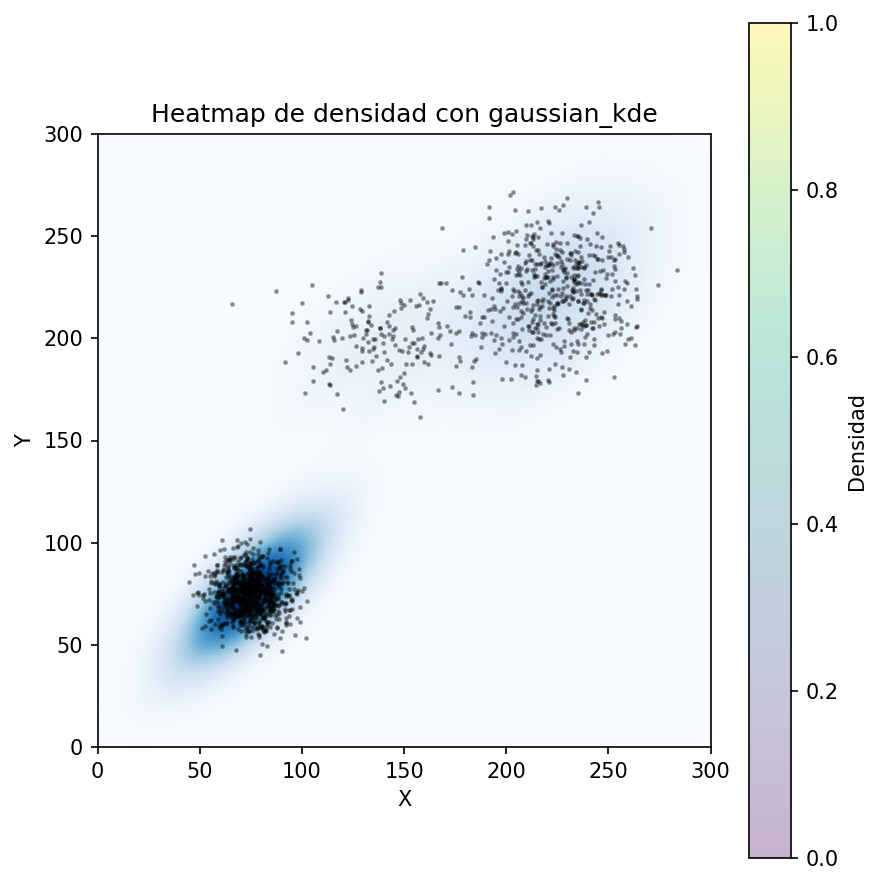

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generamos datos de prueba: mezcla de 3 clusters
np.random.seed(0)
x1 = np.random.normal(75, 10, size=1000)
y1 = np.random.normal(75, 10, size=1000)
x2 = np.random.normal(225, 20, size=500)
y2 = np.random.normal(225, 20, size=500)
x3 = np.random.normal(150, 30, size=200)
y3 = np.random.normal(200, 15, size=200)

x = np.concatenate([x1, x2, x3])
y = np.concatenate([y1, y2, y3])

# Cálculo de KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
xi = np.linspace(0, 300, 300)
yi = np.linspace(0, 300, 300)
xx, yy = np.meshgrid(xi, yi)
zi = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Plot
plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(
    zi,
    origin='lower',
    extent=[0, 300, 0, 300],
    cmap='Blues',
    interpolation='none',
    aspect='equal'
)
plt.scatter(x, y, s=2, c='k', alpha=0.3)
plt.title("Heatmap de densidad con gaussian_kde")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label='Densidad')
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def hist2DDens_with_contour(xv, yv, resolution, extent, land_mask,
                            cmap='Blues', text_threshold=0,
                            contour_color='k', contour_lw=1,
                            fontsize=6):
    """
    Dibuja un heatmap de conteos 2D con np.histogram2d, 
    anota cada celda con su cuenta (> text_threshold),
    y superpone el contorno de land_mask.

    xv, yv       : listas/arrays de coordenadas X e Y
    resolution   : tuple (n_rows, n_cols) para bins
    extent       : [xmin, xmax, ymin, ymax] para imshow
    land_mask    : array boolean shape==resolution (True = tierra)
    cmap         : colormap
    text_threshold: mínimo count para escribir texto
    contour_color: color de la línea de contorno
    contour_lw   : grosor de la línea
    fontsize     : tamaño de letra para los conteos
    """
    n_rows, n_cols = resolution
    xmin, xmax, ymin, ymax = extent

    # 1) histogram 2D
    H, xedges, yedges = np.histogram2d(
        xv, yv,
        bins=10,
        range=[[xmin, xmax], [ymin, ymax]]
    )

    # 2) preparar figura
    fig, ax = plt.subplots(figsize=(8,6), dpi=150)
    im = ax.imshow(
        H.T,  
        origin='lower',
        extent=extent,
        cmap=cmap,
        interpolation='nearest',
        aspect='auto'
    )

    # 3) anotar conteos
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    for i, xc in enumerate(x_centers):
        for j, yc in enumerate(y_centers):
            cnt = int(H[i, j])
            if cnt > text_threshold:
                ax.text(
                    xc, yc, str(cnt),
                    ha='center', va='center',
                    color='white' if im.norm(cnt) > 0.5 else 'black',
                    fontsize=fontsize
                )

    # 4) contorno de tierra
    # generar grilla de coordenadas para el mask
    xs = np.linspace(xmin, xmax, n_cols)
    ys = np.linspace(ymin, ymax, n_rows)
    XX, YY = np.meshgrid(xs, ys)
    # contour en nivel 0.5 separa True/False
    ax.contour(
        XX, YY, land_mask.astype(float),
        levels=[0.5],
        colors=contour_color,
        linewidths=contour_lw
    )

    # 5) ajustes y colorbar
    plt.colorbar(im, ax=ax, label='Counts')
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(f"Node Count Heatmap ({n_rows}×{n_cols} bins)")
    plt.tight_layout()

    return fig, ax


In [14]:
supplementary_dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/src/seacast_tools/mesh_models/supplementary_masks"
def load_supplementary_masks(supplementary_dir):
    masks = {}
    for file in os.listdir(supplementary_dir):
        if file.endswith(".npy"):
            mask_name = file.split(".")[0]
            masks[mask_name] = np.load(os.path.join(supplementary_dir, file))
            print(f"Loaded mask: {mask_name}")
    return masks

masks = load_supplementary_masks(supplementary_dir)

print(masks.keys())

Loaded mask: upwelling_zone
Loaded mask: white_cape_mask
Loaded mask: almost_top_cape_mask
Loaded mask: middle_coast_mask
Loaded mask: non_upwelling_ocean
dict_keys(['upwelling_zone', 'white_cape_mask', 'almost_top_cape_mask', 'middle_coast_mask', 'non_upwelling_ocean'])


In [15]:
import numpy as np

def count_nodes_in_masks(masks: dict, list_coords) -> dict:
    """
    Cuenta el número de nodos en cada máscara y devuelve un diccionario con los resultados.

    Parámetros
    ----------
    masks : dict[str, np.ndarray(bool)]
        Diccionario con nombre de la máscara como clave y array 2D booleano (shape (300,300))
        como valor. True = dentro de la zona.
    list_coords : array-like of shape (N, 2)
        Lista o array de coordenadas (x, y) de los N nodos, como índices en píxeles.

    Retorna
    -------
    counts : dict[str, int]
        Diccionario donde cada clave es el nombre de la máscara y el valor
        es el conteo de nodos que caen dentro de ella.
    """
    # Convertimos la lista de coords a un array Nx2 de enteros
    coords = np.asarray(list_coords, dtype=int)
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("list_coords debe tener forma (N, 2) con coordenadas (x,y).")

    xs = coords[:, 0]
    ys = coords[:, 1]

    counts = {}
    for mask_name, mask in masks.items():
        # Validamos forma y tipo
        if mask.shape != (300, 300) or mask.dtype != bool:
            raise ValueError(f"La máscara '{mask_name}' debe ser un bool array de shape (300,300).")

        # Filtramos sólo las coordenadas que estén dentro del rango [0..299]
        in_bounds = (xs >= 0) & (xs < mask.shape[1]) & (ys >= 0) & (ys < mask.shape[0])
        xs_in = xs[in_bounds]
        ys_in = ys[in_bounds]

        # Contamos cuántas de esas coordenadas están en True
        # mask[ys_in, xs_in] devuelve un array de booleans, np.count_nonzero cuenta los True
        counts[mask_name] = int(np.count_nonzero(mask[ys_in, xs_in]))

    return counts



def plot_counts_table(counts, title="Counts in Masks", save_dir=None):
    """
    Generates a bar chart with the node counts per mask and annotates each bar.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(counts.keys(), counts.values())
    ax.set_ylabel("Number of Nodes")
    ax.set_title(title)
    plt.xticks(rotation=45)

    # Annotate bars with values
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir, bbox_inches='tight')
    else:
        plt.show()
    


In [16]:
test_list_coords = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]
test_masks = {
    "mask1": np.array([[True, False], [False, True]]),
    "mask2": np.array([[False, True], [True, False]])
}
#test_counts = count_nodes_in_masks(test_masks, test_list_coords)
#print(test_counts)
#plot_test_counts_table(test_counts, title="Test Counts in Masks")

In [17]:
def mk_2d_non_uniform_graph(xy, nx, ny, land_mask, sea_depth, fixed_total_nodes=False, total_nodes_for_each_level=None, probability_distribution="mixed_sigmoid"):
    """
    Create a 2D non-uniform graph using networkx where:
    - The function takes a mesh grid defined by the xy coordinates and the number of nodes in x and y direction.
    - The function generates positions for the nodes inside the mesh.
    - The function ensures that the positions of the nodes are not too close to each other by setting a minimum distance between them.
    - The function also ensures that the positions of the nodes are within the limits of the mesh.
    - The function ensures that the nodes are not placed on land by checking the land mask.
    - The function adds edges to the graph based on the Delaunay triangulation of the nodes.

    Params:
    xy: mesh grid coordinates
    nx, ny: number of nodes in x and y direction
    land_mask: mask of land nodes
    sea_depth: depth of the sea(bathymetry)

    returns:
    - dg: directed graph with nodes and edges
    """

    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    sea_nodes = np.sum(land_mask == False)
    land_nodes = np.sum(land_mask == True)
    proportion_sea_nodes = round(sea_nodes / (sea_nodes + land_nodes), 2)
    list_coords = generate_mesh_positions_using_bathymetry(nx, ny, xm, xM, ym, yM, sea_depth, 
                                                           proportion_sea_nodes=proportion_sea_nodes, 
                                                           land_mask=land_mask, fixed_total_nodes=fixed_total_nodes,
                                                           total_nodes_for_each_level=total_nodes_for_each_level, 
                                                           distribution_type=probability_distribution)

    # Extraer coordenadas
    x_coords_values = [coord[0] for coord in list_coords]
    y_coords_values = [coord[1] for coord in list_coords]
    resolution = land_mask.shape
    extent = [xm, xM, ym, yM]

    # Llamada a la nueva función
    fig, ax = hist2DDens_with_contour(
        x_coords_values,
        y_coords_values,
        resolution=resolution,
        extent=extent,
        land_mask=land_mask,
        cmap='Blues',
        text_threshold=0,       # escribe en cada celda no vacía
        contour_color='black',
        contour_lw=1,
        fontsize=6
    )
    plt.show()

    masks = load_supplementary_masks(supplementary_dir)
    counts = count_nodes_in_masks(masks, list_coords)
    plot_counts_table(counts, title="Counts in Masks")

    
    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    print("land_points: ", land_points)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if fixed_total_nodes is True:
            if dist < np.sqrt(0.5):
                while True:
                    x_new = np.random.uniform(xm, xM)
                    y_new = np.random.uniform(ym, yM)
                    pos_new = np.array([x_new, y_new])
                    dist_new, _ = land_kdtree.query(pos_new, k=1)
                    if dist_new >= np.sqrt(0.5):
                        g.nodes[node]['pos'] = (x_new, y_new)
                        break
            else:
                g.nodes[node]["pos"] = node_pos
        else:
            if dist < np.sqrt(0.5):
                g.remove_node(node)
            else:
                g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg

In [18]:
def mk_2d_non_uniform_graph_cluster(
    xy, nx, ny, land_mask, sea_depth,
    level=1, prev_coords=None
):
    """
    Igual que antes, pero:
    - level: nivel de refinamiento (1 = malla base; >1 = clustering de prev_coords)
    - prev_coords: lista de coords del nivel anterior (requerido si level>1)
    """
    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    sea_nodes = np.sum(~land_mask)
    land_nodes = np.sum(land_mask)
    proportion_sea_nodes = round(sea_nodes / (sea_nodes + land_nodes), 2)

    list_coords = generate_mesh_positions_cluster(
        nx, ny, xm, xM, ym, yM,
        bathymetry=sea_depth,
        proportion_sea_nodes=proportion_sea_nodes,
        land_mask=land_mask,
        level=level,
        prev_coords=prev_coords
    )

    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    land_points = np.argwhere(land_mask.T).astype(np.float32)
    land_kdtree = scipy.spatial.KDTree(land_points)

    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if dist < np.sqrt(0.5):
            g.remove_node(node)
        else:
            g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    dg = networkx.DiGraph(g)
    for u, v in g.edges():
        d = np.linalg.norm(g.nodes[u]["pos"] - g.nodes[v]["pos"])
        dg.edges[u, v]["len"]   = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"]   = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg


In [19]:
import numpy as np
from sklearn.cluster import KMeans

def vertex_clustering(
    nx: int,
    ny: int,
    xm: float,
    xM: float,
    ym: float,
    yM: float,
    bathymetry: np.ndarray,
    proportion_sea_nodes: float,
    land_mask: np.ndarray,
    total_nodes_for_each_level: dict,
    fixed_total_nodes: bool
) -> list:
    """
    Genera un conjunto de nodos por clustering sobre los puntos de mar de una malla regular.

    Args:
        nx, ny: número de celdas en dirección x y y.
        xm, xM: límites de x.
        ym, yM: límites de y.
        bathymetry: array 2D con profundidad (>0 = mar, 0 = tierra).
        proportion_sea_nodes: proporción de puntos de mar a conservar (si fixed_total_nodes=False).
        land_mask: máscara booleana (True= tierra, False= mar).
        total_nodes_for_each_level: dict {nx: total_nodos_deseados}.
        fixed_total_nodes: si True, ignora proportion_sea_nodes y usa total_nodes_for_each_level[nx].

    Returns:
        List[tuple]: lista de centroides de cada cluster [(x1,y1), (x2,y2), ...].
    """

    # 1) Construye la malla de coordenadas
    np.random.seed(42)

    x = np.linspace(xm, xM, bathymetry.shape[0])
    y = np.linspace(ym, yM, bathymetry.shape[1])
    X, Y = np.meshgrid(x, y, indexing='xy')

    coords = np.vstack((X.ravel(), Y.ravel())).T
    # 2) Filtra solo los puntos de mar
    sea_mask = (~land_mask.ravel()) & (bathymetry.ravel() > 0)
    sea_coords = coords[sea_mask]
    n_sea = sea_coords.shape[0]
    if n_sea == 0:
        return []

    # 3) Determina cuántos clusters (nodos) generar
    if fixed_total_nodes:
        total = total_nodes_for_each_level.get(nx, None)
        if total is None:
            # fallback a proporción si no existe la clave
            total = int((nx * ny) * proportion_sea_nodes)
    else:
        total = int((nx * ny) * proportion_sea_nodes)

    # Nunca generar más clusters que puntos disponibles
    total = max(0, min(total, n_sea))
    if total == 0:
        return []

    # 4) Ejecuta K-means sobre los puntos de mar
    kmeans = KMeans(n_clusters=total, random_state=0)
    kmeans.fit(sea_coords)
    centers = kmeans.cluster_centers_

    # 5) Devuelve la lista de centroides
    return [tuple(c) for c in centers]


In [46]:
from scipy.spatial import Voronoi

def select_points_voronoi(points, num_samples):
    # Calcular los diagramas de Voronoi
    vor = Voronoi(points)
    
    # Filtrar las regiones de Voronoi que están bien definidas (no infinitas)
    centroids = []
    for region in vor.regions:
        if len(region) > 0 and not -1 in region:  # Filtrar regiones infinitas
            polygon = [vor.vertices[i] for i in region]
            centroid = np.mean(polygon, axis=0)
            centroids.append(centroid)
    
    # Convertir la lista de centroides a un array de numpy
    centroids = np.array(centroids)
    
    # Seleccionar los puntos basados en la distancia al centroide más cercano
    selected_points = []
    if centroids.shape[0] > 0:
        initial_point = centroids[np.random.choice(centroids.shape[0])]
        selected_points.append(initial_point)
        
        while len(selected_points) < num_samples:
            # Calcular la distancia a cada centroide
            distances = [np.linalg.norm(point - selected_points[-1]) for point in centroids]
            # Seleccionar el centroide más alejado del último punto seleccionado
            next_point = centroids[np.argmax(distances)]
            selected_points.append(next_point)
    
    return np.array(selected_points)

In [ ]:
import numpy as np

def farthest_point_sampling(points: np.ndarray, k: int) -> np.ndarray:
    """
    Select k points via farthest point sampling:
    - Start with a random initial point.
    - Iteratively add the point farthest from the current set.

    Parameters
    ----------
    points : np.ndarray, shape (N, 2)
        Candidate point coordinates.
    k : int
        Number of points to select.

    Returns
    -------
    np.ndarray, shape (min(k, N), 2)
        Coordinates of selected points.
    """
    n = points.shape[0]
    if k <= 0 or n == 0:
        return np.empty((0, points.shape[1]))

    # Pick a random first index
    selected_idxs = [int(np.random.randint(n))]
    # Compute initial distances to first point
    dist = np.linalg.norm(points - points[selected_idxs[0]], axis=1)

    # Select remaining points
    for _ in range(1, min(k, n)):
        # Next point is the one with maximum minimum-distance
        next_idx = int(np.argmax(dist))
        selected_idxs.append(next_idx)
        # Update distances
        new_dist = np.linalg.norm(points - points[next_idx], axis=1)
        dist = np.minimum(dist, new_dist)

    return points[selected_idxs]


def vertex_clustering_decimation(
    nx: int,
    ny: int,
    xm: float,
    xM: float,
    ym: float,
    yM: float,
    bathymetry: np.ndarray,
    proportion_sea_nodes: float,
    land_mask: np.ndarray,
    total_nodes_for_each_level: dict,
    fixed_total_nodes: bool
) -> list:
    """
    Genera nodos por decimación (farthest point sampling).

    Args:
        nx, ny: número de celdas en x e y.
        xm, xM / ym, yM: límites de la malla.
        bathymetry: 2D array (>0 = mar).
        proportion_sea_nodes: proporción de mar a muestrear si no es fijo.
        land_mask: True = tierra, False = mar.
        total_nodes_for_each_level: dict {nx: total_nodos}.
        fixed_total_nodes: si True, ignora proportion_sea_nodes.

    Returns:
        Lista de tuplas (x, y) con los puntos seleccionados.
    """
    # 1) Semilla y construcción de la malla según bathymetry.shape
    np.random.seed(42)
    list_coords = []
    x = np.linspace(xm, xM, bathymetry.shape[0])
    y = np.linspace(ym, yM, bathymetry.shape[1])
    X, Y = np.meshgrid(x, y, indexing='xy')
    coords = np.vstack((X.ravel(), Y.ravel())).T

    #generate_ocean_corner_nodes(land_mask, x, y, coords, list_coords)
    # 2) Filtra puntos de mar
    sea_mask = (~land_mask.ravel()) & (bathymetry.ravel() > 0)
    sea_coords = coords[sea_mask]
    n_sea = sea_coords.shape[0]
    if n_sea == 0:
        return []

    # 3) Determina cuántos nodos generar
    if fixed_total_nodes:
        total = total_nodes_for_each_level.get(nx, None)
        if total is None:
            total = int((nx * ny) * proportion_sea_nodes)
    else:
        total = int((nx * ny) * proportion_sea_nodes)

    # Ajusta para no exceder el número de puntos disponibles
    total = max(0, min(total, n_sea))
    if total == 0:
        return []
    sampled = farthest_point_sampling(sea_coords, k=total)
    #use voronoi
    #sampled = select_points_voronoi(sea_coords, num_samples=total)

    # convert to list of tuples
    list_coords = [tuple(pt) for pt in sampled]

    return list_coords



In [44]:
import numpy as np
from scipy.spatial import Voronoi

def generate_points(num_points):
    # Generar puntos aleatorios dentro de un cuadrado unitario
    points = np.random.rand(num_points, 2)
    #lx = np.linspace(0, 300, num_points)
    #ly = np.linspace(0, 300, num_points)
    #X, Y = np.meshgrid(lx, ly)
    #points = np.column_stack([X.ravel(), Y.ravel()])
    return points

def select_points_voronoi(points, num_samples):
    # Calcular los diagramas de Voronoi
    vor = Voronoi(points)
    
    # Filtrar las regiones de Voronoi que están bien definidas (no infinitas)
    centroids = []
    for region in vor.regions:
        if len(region) > 0 and not -1 in region:  # Filtrar regiones infinitas
            polygon = [vor.vertices[i] for i in region]
            centroid = np.mean(polygon, axis=0)
            centroids.append(centroid)
    
    # Convertir la lista de centroides a un array de numpy
    centroids = np.array(centroids)
    
    # Seleccionar los puntos basados en la distancia al centroide más cercano
    selected_points = []
    if centroids.shape[0] > 0:
        initial_point = centroids[np.random.choice(centroids.shape[0])]
        selected_points.append(initial_point)
        
        while len(selected_points) < num_samples:
            # Calcular la distancia a cada centroide
            distances = [np.linalg.norm(point - selected_points[-1]) for point in centroids]
            # Seleccionar el centroide más alejado del último punto seleccionado
            next_point = centroids[np.argmax(distances)]
            selected_points.append(next_point)
    
    return np.array(selected_points)

# Ejemplo de uso
num_points = 100
num_samples = 10

points = generate_points(num_points)
selected_points = select_points_voronoi(points, num_samples)

print("Puntos seleccionados utilizando Voronoi:")
print(selected_points)

#plot 



Puntos seleccionados utilizando Voronoi:
[[ 1.0749458   0.60520354]
 [-2.29943246  0.3969384 ]
 [ 1.0749458   0.60520354]
 [-2.29943246  0.3969384 ]
 [ 1.0749458   0.60520354]
 [-2.29943246  0.3969384 ]
 [ 1.0749458   0.60520354]
 [-2.29943246  0.3969384 ]
 [ 1.0749458   0.60520354]
 [-2.29943246  0.3969384 ]]


In [38]:
print(selected_points[:, 0])

[101.25 296.25   3.75 ... 296.25   3.75 296.25]


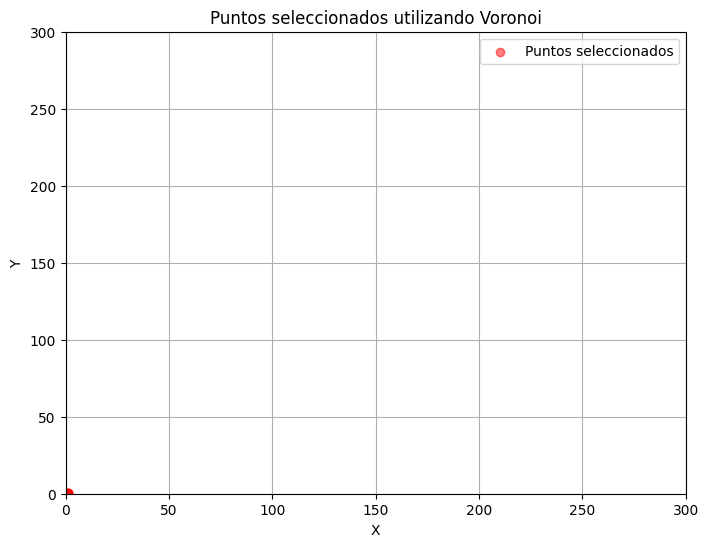

In [45]:
plt.figure(figsize=(8, 6))

# Puntos originales
#plt.scatter(points[:, 0], points[:, 1], color='blue', label='Puntos originales', alpha=0.5)

# Puntos seleccionados
plt.scatter(selected_points[:, 0], selected_points[:, 1], color='red', label='Puntos seleccionados', alpha=0.5)
plt.title("Puntos seleccionados utilizando Voronoi")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.grid()
plt.legend()
plt.show()



In [48]:
def mk_2d_non_uniform_graph_vertex(xy, nx, ny, land_mask, sea_depth, fixed_total_nodes=False, total_nodes_for_each_level=None):
    """
    Create a 2D non-uniform graph using networkx where:
    - The function takes a mesh grid defined by the xy coordinates and the number of nodes in x and y direction.
    - The function generates positions for the nodes inside the mesh.
    - The function ensures that the positions of the nodes are not too close to each other by setting a minimum distance between them.
    - The function also ensures that the positions of the nodes are within the limits of the mesh.
    - The function ensures that the nodes are not placed on land by checking the land mask.
    - The function adds edges to the graph based on the Delaunay triangulation of the nodes.

    Params:
    xy: mesh grid coordinates
    nx, ny: number of nodes in x and y direction
    land_mask: mask of land nodes
    sea_depth: depth of the sea(bathymetry)

    returns:
    - dg: directed graph with nodes and edges
    """

    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    sea_nodes = np.sum(land_mask == False)
    land_nodes = np.sum(land_mask == True)
    proportion_sea_nodes = round(sea_nodes / (sea_nodes + land_nodes), 2)
    #list_coords = vertex_clustering(nx, ny, xm, xM, ym, yM, sea_depth, proportion_sea_nodes=proportion_sea_nodes, land_mask=land_mask, total_nodes_for_each_level=total_nodes_for_each_level, fixed_total_nodes=fixed_total_nodes)
    list_coords = vertex_clustering_decimation(nx, ny, xm, xM, ym, yM, sea_depth, proportion_sea_nodes=proportion_sea_nodes,
                                                land_mask=land_mask, total_nodes_for_each_level=total_nodes_for_each_level,
                                                fixed_total_nodes=fixed_total_nodes)
    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    print("land_points: ", land_points)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if fixed_total_nodes is True:
            if dist < np.sqrt(0.5):
                while True:
                    x_new = np.random.uniform(xm, xM)
                    y_new = np.random.uniform(ym, yM)
                    pos_new = np.array([x_new, y_new])
                    dist_new, _ = land_kdtree.query(pos_new, k=1)
                    if dist_new >= np.sqrt(0.5):
                        g.nodes[node]['pos'] = (x_new, y_new)
                        break
            else:
                g.nodes[node]["pos"] = node_pos
        else:
            if dist < np.sqrt(0.5):
                g.remove_node(node)
            else:
                g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg

In [74]:
import numpy as np
from scipy.ndimage import distance_transform_edt, label

def get_african_upwelling_zone(sea_surface: np.ndarray,
                               n_pixels: int = 10) -> np.ndarray:
    """
    Gets the upwelling zone of width n_pixels *only* along
    the African coast, excluding islands.

    Parameters
    ----------
    sea_surface : np.ndarray, bool
    Mask where True = sea, False = land.
    n_pixels : int
    Width of the coastal zone in pixels (default 10).

    Returns
    -------
    np.ndarray, bool
    Mask of the upwelling zone: True = sea pixels within
    n_pixels of the African coast.
    """
    sea = sea_surface.astype(bool)
    land = ~sea

    labeled_land, n_components = label(land)

    sizes = np.bincount(labeled_land.ravel())
    sizes[0] = 0
    main_label = sizes.argmax()

    africa_mask = (labeled_land == main_label)

    dist_mask = ~africa_mask

    dist = distance_transform_edt(dist_mask)

    upwelling_zone = sea & (dist <= n_pixels)

    return upwelling_zone


In [72]:
dataset = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic"
static_dir_path = os.path.join(dataset, "static")
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))
sea_depth = np.load(os.path.join(static_dir_path, "sea_depth.npy"))
land_mask = ~sea_mask[0]
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))

In [ ]:
import numpy as np
from typing import Callable, Tuple, List, Optional

def FF(
    xmin: float,
    xmax: float,
    ymin: float,
    ymax: float,
    h: Callable[[np.ndarray], float],
    n_new: int = 5,
    max_nodes: Optional[int] = None,
    initial_A: Optional[np.ndarray] = None,
    sea_mask: np.ndarray = None
) -> np.ndarray:
    """
    Advancing-front de Fornberg & Flyer, con:
      - initial_A: semillas (x,y) iniciales (por ejemplo, la costa)
      - mask_func(p): devuelve True si el punto p=(x,y) está permitido (p.ej. mar).
    """
    rng = np.random.default_rng()
    B: List[Tuple[float, float]] = []
    # 1) Inicializar A
    if initial_A is None:
        # (el algoritmo original: línea y=ymin…)  
        A: List[Tuple[float, float]] = []
        x = xmin
        while x <= xmax:
            r0 = h(np.array([x, ymin]))
            eps_x, eps_y = rng.uniform(0, 0.1*r0, 2)
            p0 = (x + eps_x, ymin + eps_y)
            if sea_mask is None or sea_mask[int(p0[1]), int(p0[0])]:
                A.append(p0)
            x += r0
    else:
        # solo conservamos los de la semilla que estén en dominio
        A = [p for p in initial_A if (xmin <= p[0] <= xmax and ymin <= p[1] <= ymax)]

    # 2) Bucle principal
    while A and (max_nodes is None or len(B) < max_nodes):
        # escoger el candidato más bajo
        ys = [p[1] for p in A]
        idx = int(np.argmin(ys))
        p = A.pop(idx)
        if p[1] > ymax:
            break
        B.append(p)
        if max_nodes is not None and len(B) >= max_nodes:
            break

        # eliminar vecinos demasiado cercanos
        rp = h(np.array(p))
        A = [q for q in A
             if (q[0]-p[0])**2 + (q[1]-p[1])**2 >= rp**2]

        if not A:
            break

        # buscar ángulos extremos
        angles = [np.arctan2(q[1]-p[1], q[0]-p[0]) for q in A]
        aL, aR = max(angles), min(angles)
        if aR <= aL:
            aR += 2*np.pi

        # generar nuevos PDPs en el sector
        for ang in np.linspace(aL, aR, n_new+2)[1:-1]:
            x_new = p[0] + rp*np.cos(ang)
            y_new = p[1] + rp*np.sin(ang)
            # sólo si está en el rectángulo y pasa la máscara
            test = np.array([x_new, y_new])
            if (xmin <= test[0] <= xmax and ymin <= test[1] <= ymax and
                (sea_mask is None or sea_mask[int(test[1]), int(test[0])])):
                A.append((x_new, y_new))

    return np.array(B)


In [ ]:
def FF(min_x, max_x, min_y, max_y, sea_mask, nodes_to_place, n_new=5):
    """
    Generates a set of points using the advancing front method.
    The points are generated in a rectangular area defined by the
    coordinates (min_x, max_x, min_y, max_y). cited from:
    https://www.sciencedirect.com/science/article/pii/S0898122115000334?via%3Dihub#section-cited-by
    """

    placed_nodes_counter = 0
    #random_number_generator
    rng = np.random.default_rng(seed=42)
    pdp = 

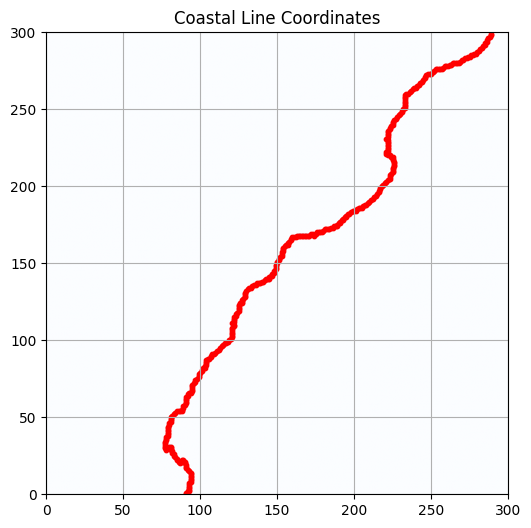

In [117]:
#
def get_coastal_line_coordinates(sea_surface: np.ndarray) -> np.ndarray:
    """
    Obtiene las coordenadas de la línea costera a partir de una máscara de superficie marina.

    Parameters
    ----------
    sea_surface : np.ndarray, bool
        Máscara donde True = mar, False = tierra.

    Returns
    -------
    np.ndarray, shape (N, 2)
        Coordenadas de los píxeles que forman la línea costera.
    """
    # Obtener las coordenadas de los píxeles que son mar (True)
    coords = np.argwhere(sea_surface == True)
    #numpy array de coordenadas (x, y)
    coords = np.array(coords, dtype=float)
    return  coords

coastal_line = get_african_upwelling_zone(sea_mask[0], 1)
coastal_line_coords = get_coastal_line_coordinates(coastal_line.T)



xmin, xmax, ymin, ymax = 0.0, 300.0, 0.0, 300.0

#draw coords
plt.figure(figsize=(6, 6))
plt.imshow(coastal_line, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='Blues', alpha=0.5)
plt.scatter(coastal_line_coords[:, 0], coastal_line_coords[:, 1], s=10, color='red')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal')
plt.title("Coastal Line Coordinates")
plt.grid(True)
plt.show()

In [118]:
import numpy as np

def distance_to_coastal_line_coords(
    pt: np.ndarray,
    coastal_coords: np.ndarray,
    base: float = 0.2,
    scale: float = 0.2
) -> float:
    """
    Calcula el radio de exclusión en el punto `pt` como:
        base + scale * (dist min a línea costera).

    Parámetros
    ----------
    pt : np.ndarray, shape (2,)
        Coordenadas (x, y) del punto de interés.
    coastal_coords : np.ndarray, shape (N, 2)
        Coordenadas normalizadas de la línea costera.
    base : float
        Radio mínimo cuando la distancia a costa es cero.
    scale : float
        Factor de escala para la distancia a la costa.

    Retorna
    -------
    float
        Radio de exclusión en `pt`.
    """
    # Distancias euclídeas a todos los puntos de costa
    dists = np.linalg.norm(coastal_coords - pt, axis=1)
    # Tomamos la mínima
    dmin = dists.min()
    return base + scale * dmin



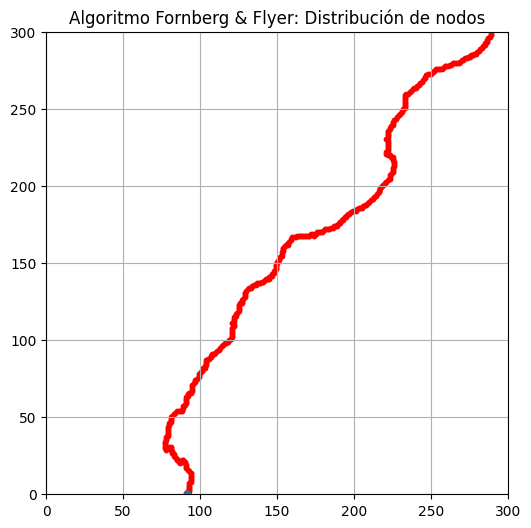

In [ ]:
# --- Ejemplo de uso ---
# Definimos el dominio y función de radio variable

coastal_line = get_african_upwelling_zone(sea_surface= sea_mask[0], n_pixels=1)
coastal_line_coords = get_coastal_line_coordinates(coastal_line.T)

# 1. Extraer coords de costa en píxeles y reordenar
coords_pix = np.argwhere(coastal_line)        # (y_pix, x_pix)
coords = coords_pix[:, [1, 0]].astype(float)   # (x_pix, y_pix)

H, W = coastal_line.shape
# 2. Normalizar
coords[:, 0] = coords[:, 0] / (W - 1) * (xmax - xmin) + xmin
coords[:, 1] = coords[:, 1] / (H - 1) * (ymax - ymin) + ymin

# Ahora:
coastal_line_coords_normalizadas = coords  # shape (N,2)

def h(pt: np.ndarray) -> float:
    return distance_to_coastal_line_coords(pt, coastal_line_coords_normalizadas)



def mask_func(pt: np.ndarray) -> bool:
    # pt = [x, y] en [xmin,xmax]×[ymin,ymax]
    # convertir a índices de píxel
    j = int((pt[0] - xmin)/(xmax - xmin) * (W - 1))
    i = int((pt[1] - ymin)/(ymax - ymin) * (H - 1))
    # asegurarse que no se salga de rango
    if not (0 <= i < H and 0 <= j < W):
        return False
    return sea_mask[i, j]  # True = mar

# Generar exactamente 100 nodos (o menos si el dominio se llena antes)
pts = FF(xmin, xmax, ymin, ymax, h, 
         n_new=5, 
         max_nodes=3568, initial_A=coastal_line_coords_normalizadas, 
         mask_func=mask_func)

# Visualización
plt.figure(figsize=(6, 6))
#plot coastal line coordinates
plt.scatter(coastal_line_coords[:, 0], coastal_line_coords[:, 1], s=10, color='red')
plt.scatter(pts[:, 0], pts[:, 1], s=10)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal')
plt.title("Algoritmo Fornberg & Flyer: Distribución de nodos")
plt.grid(True)
plt.show()


In [ ]:
def mk_2d_non_uniform_graph_radius_densification(xy, nx, ny, land_mask, sea_depth, fixed_total_nodes=False, total_nodes_for_each_level=None):
    """
    Create a 2D non-uniform graph using networkx where:
    - The function takes a mesh grid defined by the xy coordinates and the number of nodes in x and y direction.
    - The function generates positions for the nodes inside the mesh.
    - The function ensures that the positions of the nodes are not too close to each other by setting a minimum distance between them.
    - The function also ensures that the positions of the nodes are within the limits of the mesh.
    - The function ensures that the nodes are not placed on land by checking the land mask.
    - The function adds edges to the graph based on the Delaunay triangulation of the nodes.

    Params:
    xy: mesh grid coordinates
    nx, ny: number of nodes in x and y direction
    land_mask: mask of land nodes
    sea_depth: depth of the sea(bathymetry)

    returns:
    - dg: directed graph with nodes and edges
    """

    xm, xM = np.amin(xy[0][0, :]), np.amax(xy[0][0, :])
    ym, yM = np.amin(xy[1][:, 0]), np.amax(xy[1][:, 0])

    sea_nodes = np.sum(land_mask == False)
    land_nodes = np.sum(land_mask == True)
    proportion_sea_nodes = round(sea_nodes / (sea_nodes + land_nodes), 2)
    #list_coords = 

    # Extraer coordenadas
    x_coords_values = [coord[0] for coord in list_coords]
    y_coords_values = [coord[1] for coord in list_coords]
    resolution = land_mask.shape
    extent = [xm, xM, ym, yM]

    # Llamada a la nueva función
    fig, ax = hist2DDens_with_contour(
        x_coords_values,
        y_coords_values,
        resolution=resolution,
        extent=extent,
        land_mask=land_mask,
        cmap='Blues',
        text_threshold=0,       # escribe en cada celda no vacía
        contour_color='black',
        contour_lw=1,
        fontsize=6
    )
    plt.show()

    masks = load_supplementary_masks(supplementary_dir)
    counts = count_nodes_in_masks(masks, list_coords)
    plot_counts_table(counts, title="Counts in Masks")

    
    g = networkx.Graph()
    for coord in list_coords:
        g.add_node(coord)

    # kdtree for nearest neighbor search of land nodes
    land_points = np.argwhere(land_mask.T).astype(np.float32)
    print("land_points: ", land_points)
    land_kdtree = scipy.spatial.KDTree(land_points)

    # add nodes excluding land
    for node in list(g.nodes):
        node_pos = np.array(node, dtype=np.float32)
        dist, _ = land_kdtree.query(node_pos, k=1)
        if fixed_total_nodes is True:
            if dist < np.sqrt(0.5):
                while True:
                    x_new = np.random.uniform(xm, xM)
                    y_new = np.random.uniform(ym, yM)
                    pos_new = np.array([x_new, y_new])
                    dist_new, _ = land_kdtree.query(pos_new, k=1)
                    if dist_new >= np.sqrt(0.5):
                        g.nodes[node]['pos'] = (x_new, y_new)
                        break
            else:
                g.nodes[node]["pos"] = node_pos
        else:
            if dist < np.sqrt(0.5):
                g.remove_node(node)
            else:
                g.nodes[node]["pos"] = node_pos

    add_Delaunay_edges(g)

    # remove edges that goes across land
    for u, v in list(g.edges()):
        if crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], land_mask):
            g.remove_edge(u, v)

    # turn into directed graph
    dg = networkx.DiGraph(g)

    # add node data
    for u, v in g.edges():
        d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
        dg.edges[u, v]["len"] = d
        dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
        dg.add_edge(v, u)
        dg.edges[v, u]["len"] = d
        dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

    # add self edge if needed
    for v, degree in list(dg.degree()):
        if degree <= 1:
            dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

    return dg

In [23]:
fixed_total_nodes = True
total_nodes_for_each_level = {81: 3568, 27: 394, 9: 45}
probability_distribution="mixed_sigmoid"
save_dir = os.path.join("figures", "hierarchical")
graph_type = "vertex"
#graph_type = "bathymetry_base"

In [49]:
g = mk_2d_non_uniform_graph_vertex(xy, 81, 81, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes, 
                            total_nodes_for_each_level=total_nodes_for_each_level)

g1 = mk_2d_non_uniform_graph_vertex(xy, 27, 27, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes,
                            total_nodes_for_each_level=total_nodes_for_each_level)

g2 = mk_2d_non_uniform_graph_vertex(xy, 9, 9, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes, 
                            total_nodes_for_each_level=total_nodes_for_each_level)
graph_list = [g, g1, g2]

land_points:  [[ 59. 162.]
 [ 59. 163.]
 [ 60. 182.]
 ...
 [299. 297.]
 [299. 298.]
 [299. 299.]]


IndexError: index 300 is out of bounds for axis 1 with size 300

total amount of edges in the graph:  21042
Level 1:
total_nodes: 3568
min_degree: 4
max_degree: 18
average_degree: 11.794843049327355
median_degree: 12.0
percentile_25_degree: 10.0
percentile_75_degree: 12.0
IQR_degree: 2.0
total_edges: 21042
Distribución de grados:
Grado 4: 1 nodos
Grado 6: 12 nodos
Grado 8: 184 nodos
Grado 10: 852 nodos
Grado 12: 1717 nodos
Grado 14: 711 nodos
Grado 16: 90 nodos
Grado 18: 1 nodos
Level 2:
total_nodes: 394
min_degree: 6
max_degree: 16
average_degree: 11.309644670050762
median_degree: 12.0
percentile_25_degree: 10.0
percentile_75_degree: 12.0
IQR_degree: 2.0
total_edges: 2228
Distribución de grados:
Grado 6: 9 nodos
Grado 8: 36 nodos
Grado 10: 104 nodos
Grado 12: 183 nodos
Grado 14: 57 nodos
Grado 16: 5 nodos
Level 3:
total_nodes: 45
min_degree: 4
max_degree: 16
average_degree: 9.422222222222222
median_degree: 10.0
percentile_25_degree: 8.0
percentile_75_degree: 12.0
IQR_degree: 4.0
total_edges: 212
Distribución de grados:
Grado 4: 3 nodos
Grado 6: 4 n

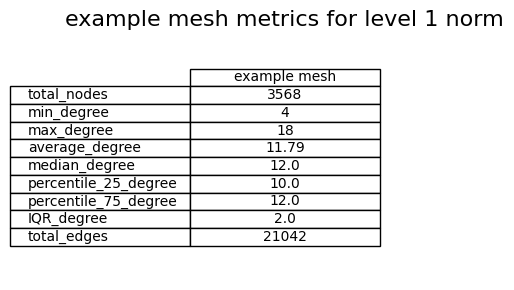

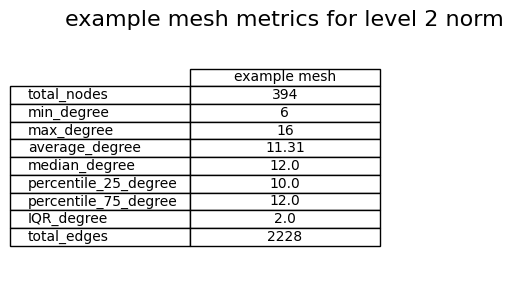

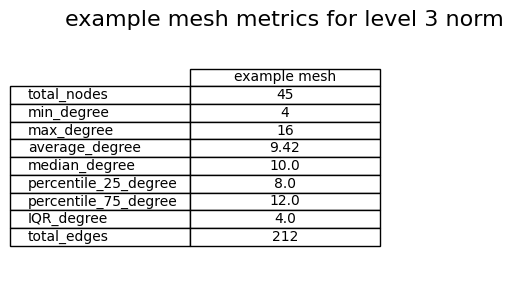

In [ ]:
#select x axis of the graph
print("total amount of edges in the graph: ", g.number_of_edges())

def metrics_foreach_level(level, g):
    mm.plot_graph_networkx(g, title=f"example {level} norm", level=None, graph_type=graph_type, plot_edges=True, save_dir=save_dir)
    metrics = mm.metrics_from_networkx_graph(g, None)
    mm.plot_degree_distribution(metrics["count_degrees"], title=f"degree distribution for example level {level} norm", graph_type = graph_type, save_dir=save_dir)
    mm.create_metrics_table(
                    metrics, None,
                    columns_names=["example mesh"],
                    metrics_to_avoid=["count_degrees"],
                    title=f"example mesh metrics for level {level} norm", 
                    graph_type= graph_type, save_dir=save_dir
                )  
    for key, value in metrics.items():
        if key != "count_degrees":
            print(f"{key}: {value}")
    if "count_degrees" in metrics:
        print("Distribución de grados:")
        for degree, count in sorted(metrics["count_degrees"].items()):
            print(f"Grado {degree}: {count} nodos")

levels = [1, 2,3]
for level in levels:
    print(f"Level {level}:")
    g = graph_list[level-1]
    metrics_foreach_level(level, g)
    #print("/n")

In [169]:
def generate_uniform_distribution(ocean_mask, seed=42):
        """
        Generate a uniform distribution of points in the ocean mask.

        Args:
            ocean_mask (numpy.ndarray): The ocean mask.
            N (int): The number of points to generate.
            seed (int): The random seed.

        Returns:
            numpy.ndarray: The generated points.
        """
        np.random.seed(seed)

    # 2) Distancia de cada píxel oceánico al píxel de tierra más cercano
    #    (distance_transform_edt mide distancia a ceros en la máscara)
        dist_to_land = distance_transform_edt(ocean_mask)
        coastal_margin = np.sqrt(0.6)  # Distancia mínima a la costa (en píxeles)
        # 3) Construir máscara de “válidos”: océano y suficientemente lejos de la costa
        valid = (ocean_mask) & (dist_to_land >= coastal_margin)

        # 5) Crear distribución uniforme sobre los píxeles válidos
        p = np.zeros_like(dist_to_land, dtype=float)
        p[valid] = 1.0
        p /= p.sum()

        return p

In [170]:
ocean_masl = ~land_mask
p = generate_uniform_distribution(ocean_masl, seed=42)
print(p.shape)

(300, 300)


Esquinas en mar (máscara invertida): {'bottom_left': (np.int64(0), np.int64(0)), 'bottom_right': (np.int64(0), np.int64(299)), 'top_left': (np.int64(94), np.int64(8)), 'top_right': (np.int64(289), np.int64(299))}


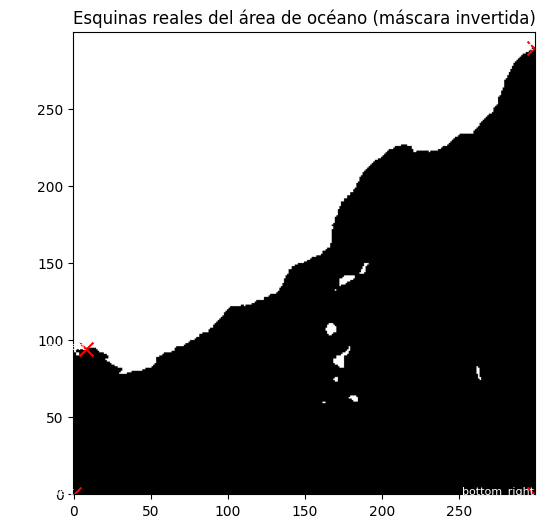

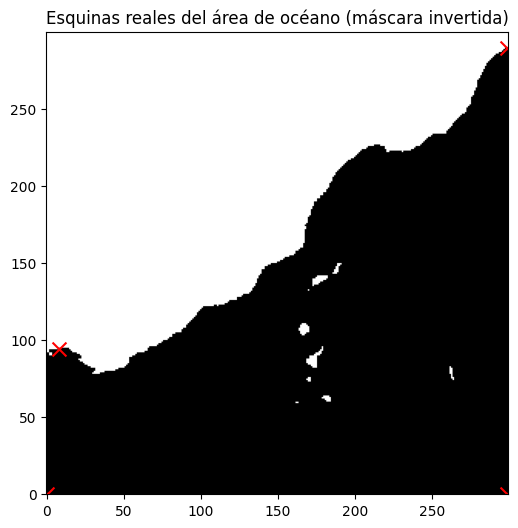

In [171]:
import numpy as np
import matplotlib.pyplot as plt

def get_ocean_corners(mask, inverted=False):
    """
    Para una máscara 2D booleana, devuelve las 4 esquinas del área de océano.
    
    Parámetros:
      mask      — array 2D booleano
      inverted  — si True, interpreta mask==False como océano (y True como tierra)
    """
    ocean_mask = (~mask) if inverted else mask
    
    # Índices de todas las celdas de mar
    rows, cols = np.where(ocean_mask)
    if rows.size == 0:
        raise ValueError("La máscara no contiene ningún punto de océano")
    
    # Bounding‑box del océano
    min_r, max_r = rows.min(), rows.max()
    min_c, max_c = cols.min(), cols.max()
    targets = {
        'bottom_left':  (min_r, min_c),
        'bottom_right': (min_r, max_c),
        'top_left':     (max_r, min_c),
        'top_right':    (max_r, max_c),
    }
    
    # Para cada vértice del bounding‑box, busca el True más cercano
    nearest = {}
    for name, (tr, tc) in targets.items():
        # calcula distancia al cuadrado a cada punto de mar
        d2 = (rows - tr)**2 + (cols - tc)**2
        idx = np.argmin(d2)
        nearest[name] = (rows[idx], cols[idx])
    return nearest

mask2d = land_mask.T            
corners = get_ocean_corners(mask2d, inverted=True)
print("Esquinas en mar (máscara invertida):", corners)

plt.figure(figsize=(6,6))
plt.imshow(mask2d, origin="lower", cmap="gray")

rows, cols = zip(*corners.values())
plt.scatter(cols, rows, marker="x", s=100, color="red")

for name, (r, c) in corners.items():
    plt.text(c, r, name, color="white", fontsize=8, ha='right')

plt.title("Esquinas reales del área de océano (máscara invertida)")
plt.show()

#plot land_mask.T
plt.figure(figsize=(6,6))
plt.imshow(land_mask.T, origin="lower",cmap="gray")
plt.scatter(cols, rows, marker="x", s=100, color="red")
plt.title("Esquinas reales del área de océano (máscara invertida)")
plt.show()


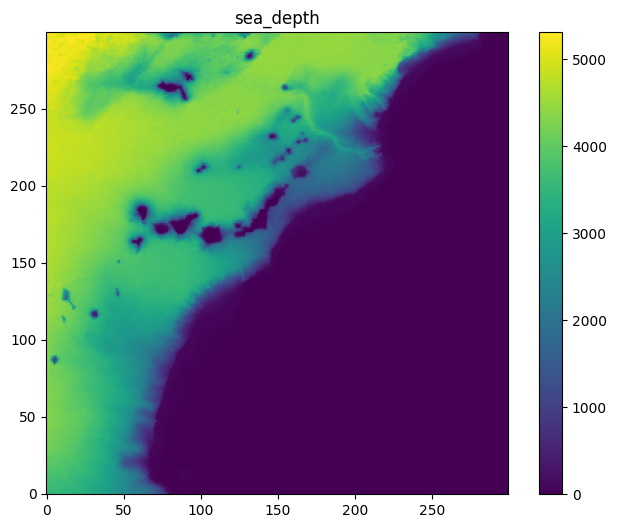

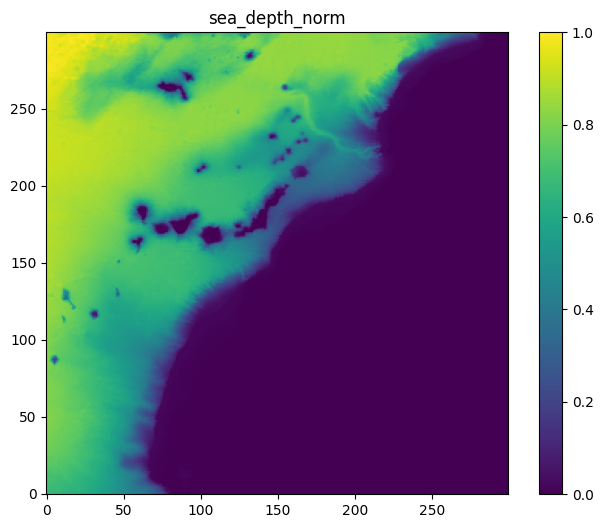

In [172]:
#normalize sea_depth to 0-1
#formula = (x - min) / (max - min)

sea_depth_norm = (sea_depth - sea_depth.min()) / (sea_depth.max() - sea_depth.min())
#plot sea_depth
plt.figure(figsize=(8, 6))
plt.imshow(sea_depth, origin='lower', cmap='viridis')
plt.title("sea_depth")
plt.colorbar()
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(sea_depth_norm, origin='lower', cmap='viridis')
plt.title("sea_depth_norm")
plt.colorbar()
plt.show()


In [173]:
#dg = mk_2d_non_uniform_graph(xy, 81,81, land_mask, sea_depth)
## nivel 1
#base_coords = generate_mesh_positions_cluster(
#    81, 81, 0, 299, 0, 299,
#    bathymetry=sea_depth,
#    proportion_sea_nodes=0.55,
#    land_mask=land_mask,
#    level=1
#)
##mas de 40 minutos sin terminar
#dg2 = mk_2d_non_uniform_graph_cluster(
#    xy, 27, 27, land_mask, sea_depth,
#    level=2, prev_coords=base_coords
#)
#
#mm.plot_graph_networkx(dg2, title=f"example {2} norm cluster", level=None, graph_type="cluester", plot_edges=True, save_dir="figures")
#
#

In [174]:
fixed_total_nodes = True
total_nodes_for_each_level = {81: 3568, 27: 394, 9: 45}
probability_distribution="mixed_sigmoid"

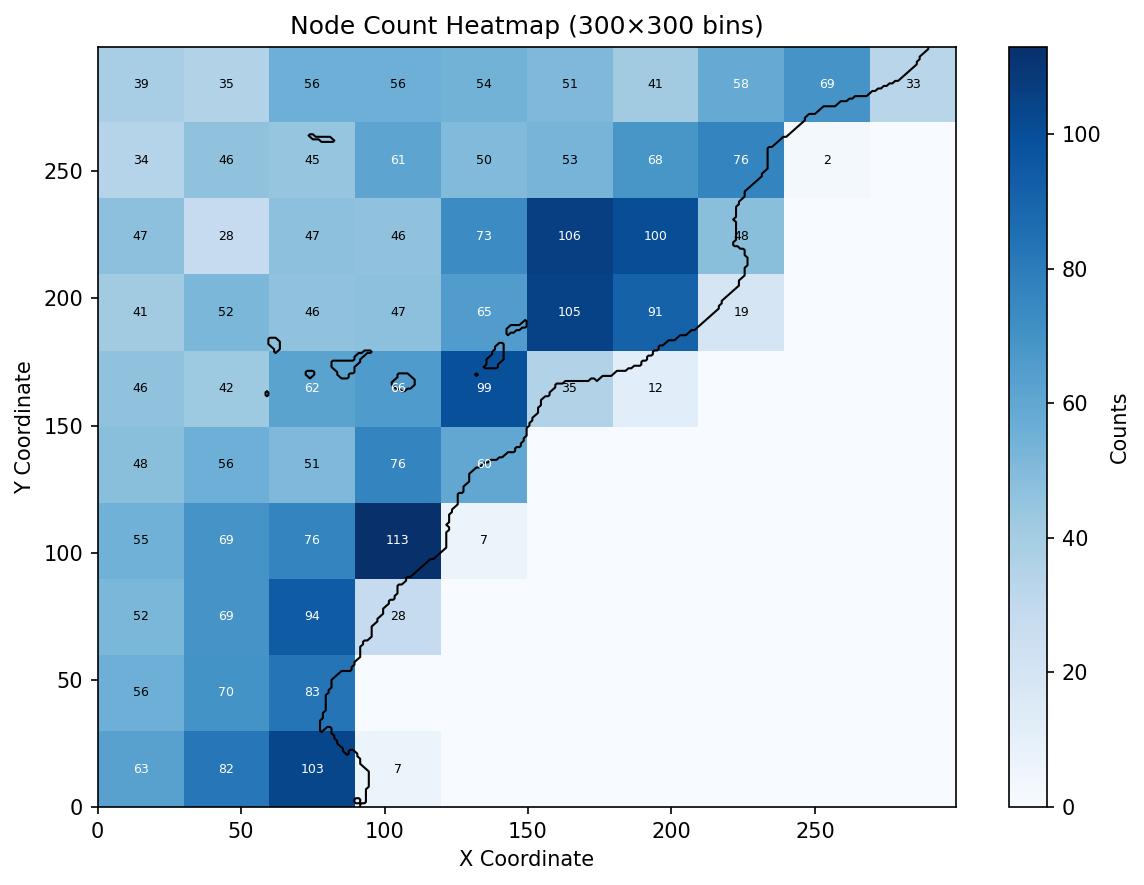

Loaded mask: upwelling_zone
Loaded mask: white_cape_mask
Loaded mask: almost_top_cape_mask
Loaded mask: middle_coast_mask
Loaded mask: non_upwelling_ocean


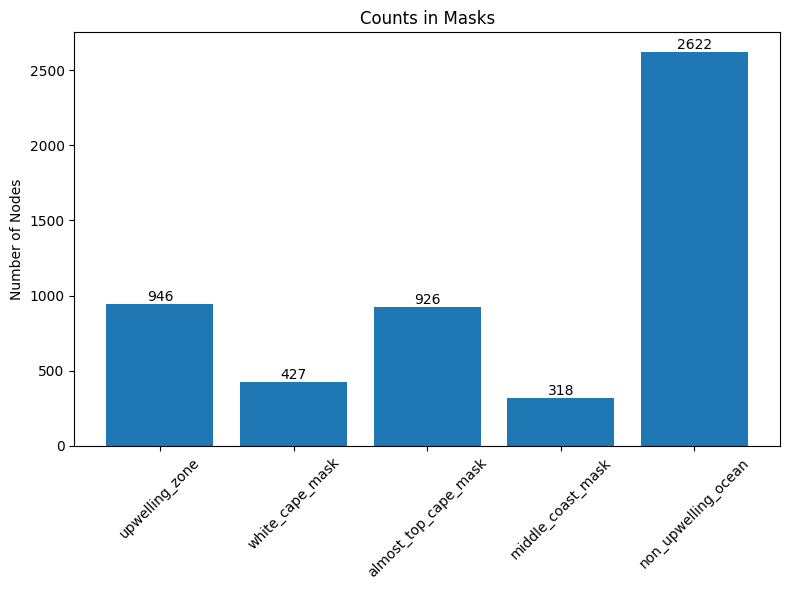

land_points:  [[ 59. 162.]
 [ 59. 163.]
 [ 60. 182.]
 ...
 [299. 297.]
 [299. 298.]
 [299. 299.]]


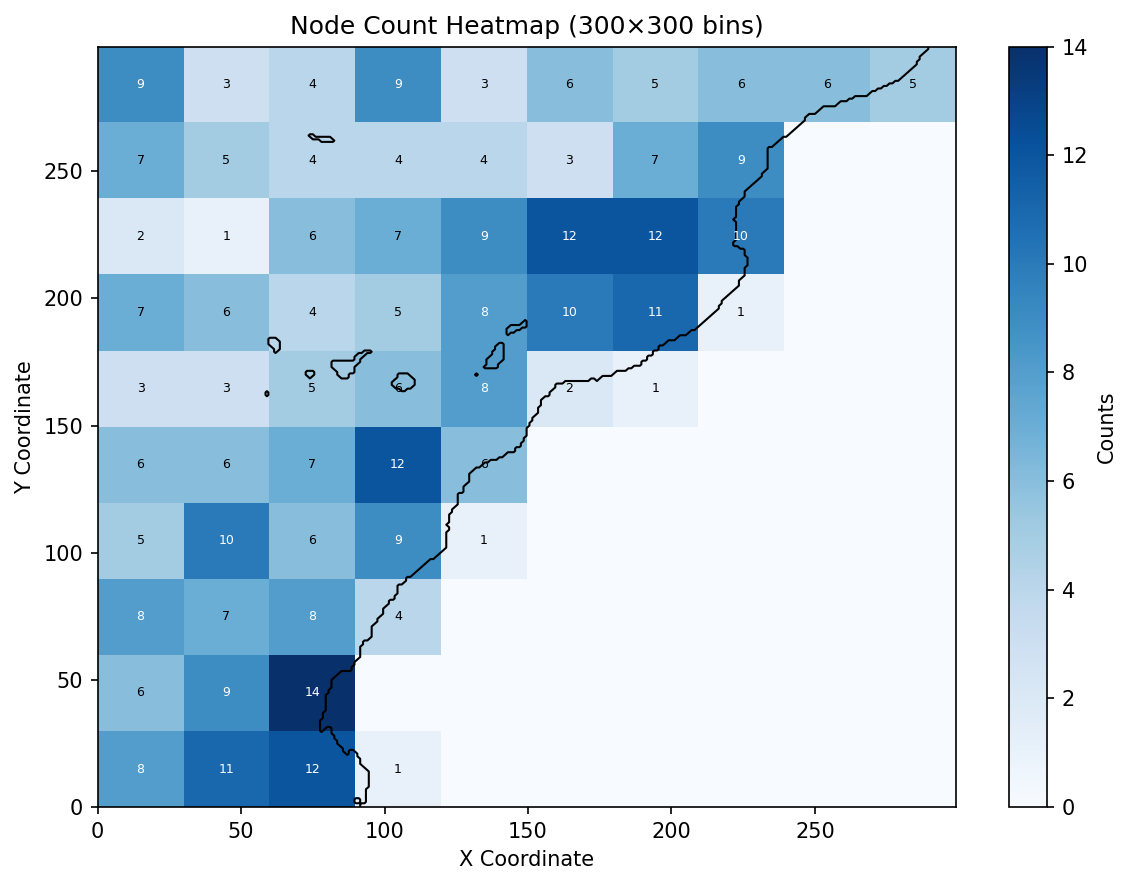

Loaded mask: upwelling_zone
Loaded mask: white_cape_mask
Loaded mask: almost_top_cape_mask
Loaded mask: middle_coast_mask
Loaded mask: non_upwelling_ocean


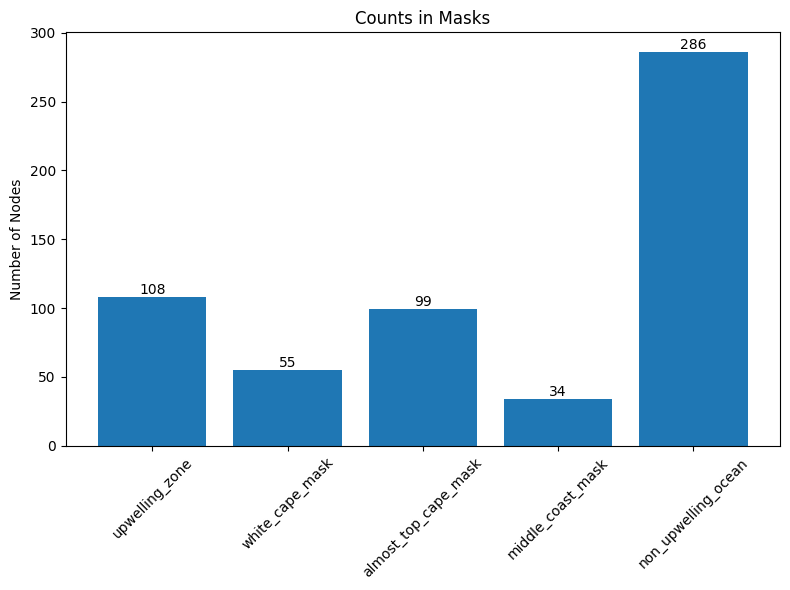

land_points:  [[ 59. 162.]
 [ 59. 163.]
 [ 60. 182.]
 ...
 [299. 297.]
 [299. 298.]
 [299. 299.]]


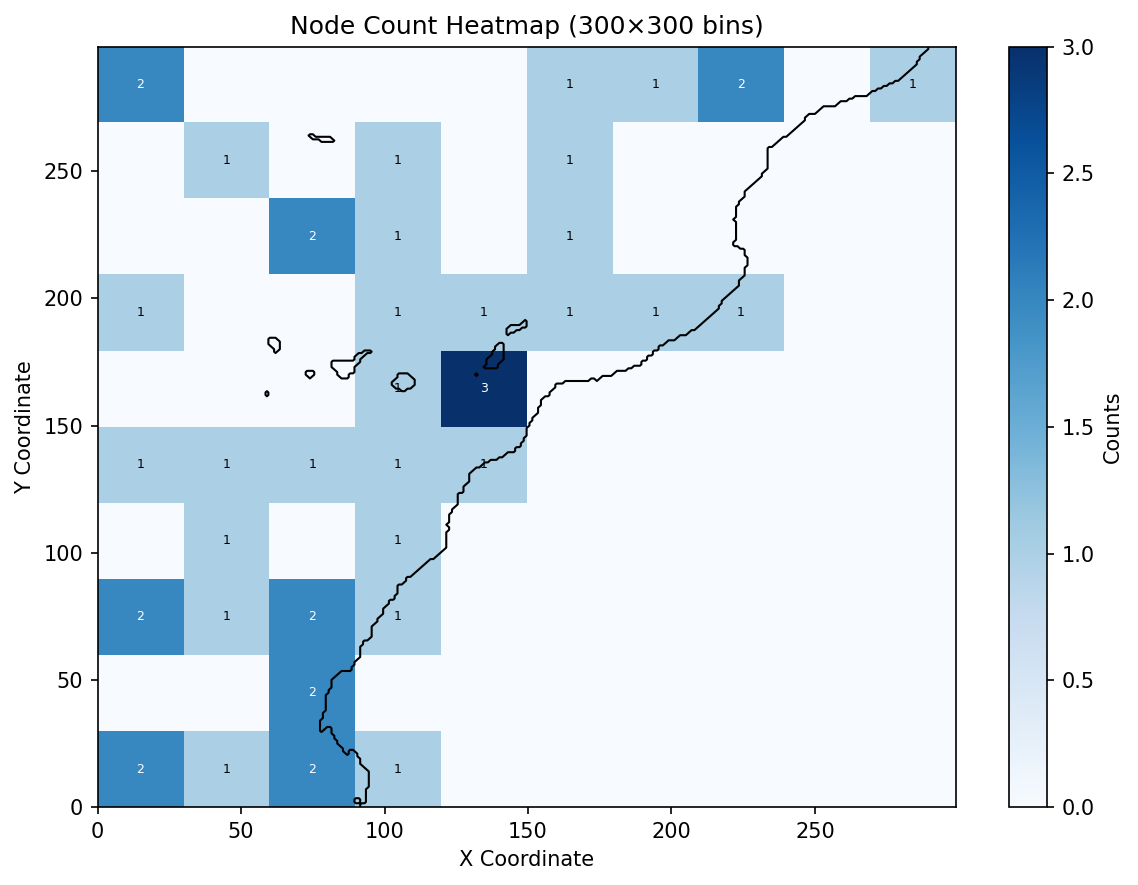

Loaded mask: upwelling_zone
Loaded mask: white_cape_mask
Loaded mask: almost_top_cape_mask
Loaded mask: middle_coast_mask
Loaded mask: non_upwelling_ocean


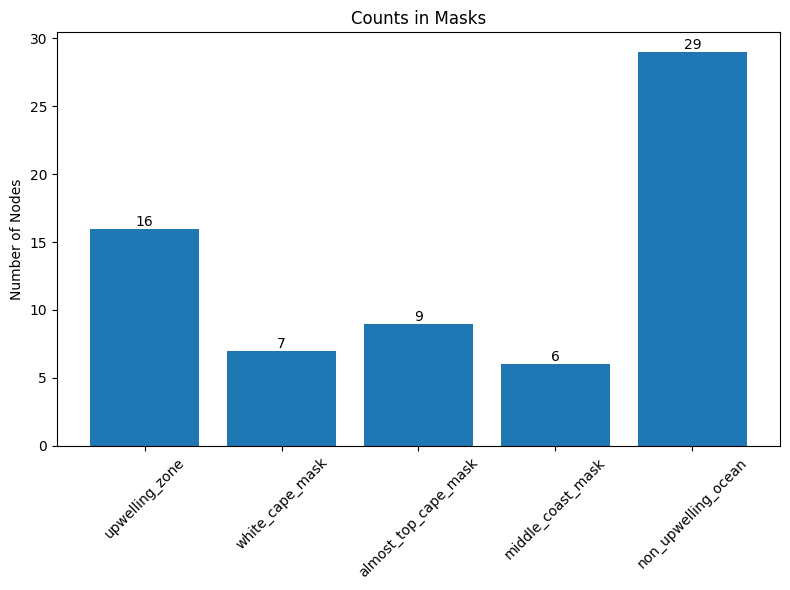

land_points:  [[ 59. 162.]
 [ 59. 163.]
 [ 60. 182.]
 ...
 [299. 297.]
 [299. 298.]
 [299. 299.]]


In [175]:
g = mk_2d_non_uniform_graph(xy, 81, 81, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes, 
                            total_nodes_for_each_level=total_nodes_for_each_level, 
                            probability_distribution=probability_distribution)

g1 = mk_2d_non_uniform_graph(xy, 27, 27, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes,
                            total_nodes_for_each_level=total_nodes_for_each_level, 
                            probability_distribution=probability_distribution)

g2 = mk_2d_non_uniform_graph(xy, 9, 9, land_mask, sea_depth, 
                            fixed_total_nodes=fixed_total_nodes, 
                            total_nodes_for_each_level=total_nodes_for_each_level, 
                            probability_distribution=probability_distribution)
graph_list = [g, g1, g2]

In [ ]:
save_dir = os.path.join("figures", "hierarchical")
graph_type = "sigmoid"
#graph_type = "bathymetry_base"

In [ ]:
#select x axis of the graph
def metrics_foreach_level(level, g):
    mm.plot_graph_networkx(g, title=f"example {level} norm", level=None, graph_type=graph_type, plot_edges=True, save_dir=save_dir)
    metrics = mm.metrics_from_networkx_graph(g, None)
    mm.plot_degree_distribution(metrics["count_degrees"], title=f"degree distribution for example level {level} norm", graph_type = graph_type, save_dir=save_dir)
    mm.create_metrics_table(
                    metrics, None,
                    columns_names=["example mesh"],
                    metrics_to_avoid=["count_degrees"],
                    title=f"example mesh metrics for level {level} norm", 
                    graph_type= graph_type, save_dir=save_dir
                )  
    for key, value in metrics.items():
        if key != "count_degrees":
            print(f"{key}: {value}")
    if "count_degrees" in metrics:
        print("Distribución de grados:")
        for degree, count in sorted(metrics["count_degrees"].items()):
            print(f"Grado {degree}: {count} nodos")

levels = [1, 2,3]
for level in levels:
    print(f"Level {level}:")
    g = graph_list[level-1]
    metrics_foreach_level(level, g)
    #print("/n")
    print("----------------------------------------------")

In [ ]:
#filepath = os.path.join("figures", "hierarchical", "sea_bathimetry_image.svg")
#plt.figure(figsize=(8, 6))
#plt.imshow(sea_depth, origin='lower', cmap='viridis')
#plt.title("sea_depth_download_data")
#plt.colorbar()
#plt.savefig(filepath, format="svg")

In [ ]:
#comprobar distancia minima entre nodos
min_distances = []
for u, v in g.edges():
    dist = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
    min_distances.append(dist)
print("Distancia mínima entre nodos:", min(min_distances))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# -------------------------------
# Función para filtrar nodos cercanos (radio mínimo)
def enforce_minimum_distance(points, min_radius):
    """
    Filtra los puntos candidatos para asegurar que ninguno esté a una distancia menor a min_radius de otro.
    
    Args:
        points (np.ndarray): Array de puntos candidatos de forma (n, 2).
        min_radius (float): Distancia mínima permitida entre puntos.
        
    Returns:
        np.ndarray: Array de puntos aceptados.
    """
    accepted = []
    # Procesa los puntos en orden aleatorio
    indices = np.random.permutation(len(points))
    for idx in indices:
        pt = points[idx]
        if len(accepted) == 0:
            accepted.append(pt)
        else:
            accepted_arr = np.array(accepted)
            # Verifica que la distancia de pt a cada punto aceptado sea >= min_radius
            if np.all(np.linalg.norm(accepted_arr - pt, axis=1) >= min_radius):
                accepted.append(pt)
    return np.array(accepted)

# -------------------------------
# Función para filtrar aristas largas
def filter_long_edges(points, edge_index, max_distance):
    """
    Filtra las aristas, eliminando aquellas cuya distancia entre nodos es mayor que max_distance.
    
    Args:
        points (np.ndarray): Array de puntos (n, 2).
        edge_index (np.ndarray): Array con forma (2, n_edges) que contiene los índices de las aristas.
        max_distance (float): Distancia máxima permitida para mantener una arista.
        
    Returns:
        np.ndarray: Array con las aristas filtradas (forma (2, n_edges_filtradas)).
                  Si no hay aristas filtradas, retorna un array con forma (2, 0).
    """
    filtered_edges = []
    # Procesa cada arista de la conectividad
    for i in range(edge_index.shape[1]):
        idx1, idx2 = edge_index[0, i], edge_index[1, i]
        p1, p2 = points[idx1], points[idx2]
        dist = np.linalg.norm(p1 - p2)
        if dist <= max_distance:
            filtered_edges.append([idx1, idx2])
    
    # Aseguramos que se retorne un array de forma (2, n_edges) incluso si está vacío
    if len(filtered_edges) == 0:
        return np.empty((2, 0), dtype=int)
    else:
        return np.array(filtered_edges).T


In [ ]:
bathymetry = np.load("D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/static/sea_depth.npy")

In [ ]:
nx, ny = bathymetry.shape  # (300, 300)
x = np.linspace(0, 300, nx)
y = np.linspace(0, 300, ny)
X, Y = np.meshgrid(x, y)

epsilon = 1e-3  # Pequeña constante para evitar división por cero
density = np.where(bathymetry > 0, 1.0 / (bathymetry + epsilon), 0)
p = density / np.sum(density)  # Normalizar para obtener distribución de probabilidad

In [ ]:
#plot p
plt.figure(figsize=(8, 6))
plt.imshow(p, origin='lower', cmap='viridis')
plt.title("p (probability distribution)")

plt.colorbar()
plt.show()


In [ ]:
bathymetry_norm = (bathymetry - bathymetry.min()) / (bathymetry.max() - bathymetry.min())

epsilon = 1e-3  # Pequeña constante para evitar división por cero
density_norm = np.where(bathymetry_norm > 0, 1.0 / (bathymetry_norm + epsilon), 0)
p_norm = density_norm / np.sum(density_norm)  # Normalizar para obtener distribución de probabilidad

In [ ]:
#plot p
plt.figure(figsize=(8, 6))
plt.imshow(p_norm, origin='lower', cmap='viridis')
plt.title("p (probability distribution)")
plt.colorbar()
plt.show()


### Hallar proporcion de nodos generada por el uniforme

In [ ]:
#obtener cantidad de nodos de oceano 
sea_nodes = np.sum(sea_mask == True)
print("sea_nodes", sea_nodes)
#obtener cantidad de nodos de tierra
land_nodes = np.sum(sea_mask == False)
print("land_nodes", land_nodes)
#proporción de nodos de oceano
#redondear a 2 decimales
proportion_sea_nodes = round(sea_nodes / (sea_nodes + land_nodes), 2)
print("proportion_sea_nodes", proportion_sea_nodes)
#proporción de nodos de tierra
proportion_land_nodes = round(land_nodes / (sea_nodes + land_nodes), 2)
print("proportion_land_nodes", proportion_land_nodes)
n_nodes_x = 27
n_nodes_y = 27
nodes_to_generate = (n_nodes_x * n_nodes_y )* proportion_sea_nodes
print("nodos_a_generar", nodes_to_generate)

uniform_proportion = []
nodes_generated_by_uniform = [3568, 394, 45]
nodes_to_generate = [81*81, 27*27, 9*9]
for i in range(len(nodes_to_generate)):
    uniform_proportion.append(round(nodes_generated_by_uniform[i] / nodes_to_generate[i], 4))

print("proporcion_uniforme", uniform_proportion)
mean_proportion = round(np.mean(uniform_proportion), 2)
print("proporcion_unica", mean_proportion)


In [ ]:
plt.figure(figsize=(8, 6))
p_norm_without_zeros = p_norm[p_norm > 0]

plt.hist(p_norm_without_zeros, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Probabilidad normalizada')
plt.ylabel('Frecuencia')
plt.xlim(min(p_norm_without_zeros), max(p_norm_without_zeros))
plt.title('Histograma de la distribución de probabilidades')
plt.grid(True)
plt.show()


### Pruebas de obtención de un valor mínimo de separación entre nodos según una resolución dada.

In [ ]:
prop = (bathymetry.shape[0]* bathymetry.shape[1]) / (81*81)
print("prop: ", prop)
prop_square = prop/4
print("prop_square", prop_square)
prop_radius = prop_square/2
circle_area = np.pi * (prop_radius**2)
circle_perimeter = 2 * np.pi * prop_radius
print("prop_radius", prop_radius)
print("circle_area", circle_area)
print(np.sqrt((circle_area/(prop))))

In [ ]:
# 4. Muestreo ponderado para obtener candidatos (sobre-muestreo)
n_candidates = 81*81 # Se recomienda sobre-muestrear para luego filtrar
indices = np.random.choice(np.arange(nx * ny), size=n_candidates, replace=False, p=p.ravel())
selected_x = X.ravel()[indices]
selected_y = Y.ravel()[indices]
candidate_points = np.vstack([selected_x, selected_y]).T

# 5. Filtrar los candidatos para asegurar una distancia mínima entre nodos
min_radius = 0.8205804865303314  # Radio mínimo entre nodos (ajusta según tu dominio)
filtered_points = enforce_minimum_distance(candidate_points, min_radius)
#filtered_points= candidate_points
print(filtered_points[0])
print(f"Número de nodos después de filtrar por radio mínimo: {len(filtered_points)}")

# 6. Generar la conectividad usando triangdulación de Delaunay
tri = Delaunay(filtered_points)

# Extraer las aristas de la triangulación (sin duplicados)
edges_set = set()
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            edge = tuple(sorted([simplex[i], simplex[j]]))
            edges_set.add(edge)
edge_index = np.array(list(edges_set)).T  # Con forma (2, n_edges)

# 7. Filtrar aristas que conecten nodos muy lejanos
max_distance = 200  # Distancia máxima permitida para conservar una arista (ajusta según tu dominio)
filtered_edge_index = filter_long_edges(filtered_points, edge_index, max_distance)
# Control para evitar el error si no hay ninguna arista filtrada
n_edges = filtered_edge_index.shape[1] if filtered_edge_index.ndim == 2 else 0
print(f"Número de aristas después de filtrar por distancia: {n_edges}")

# -------------------------------
# Visualización de resultados
# Visualización 1: Batimetría y nodos filtrados
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, bathymetry, shading='auto', cmap='viridis')
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], color='red', s=10, label='Nodos filtrados')
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Nodos muestreados con batimetría y separación mínima")
plt.colorbar(label="Profundidad")
plt.legend()
plt.show()

# Visualización 2: Triangulación y aristas filtradas
plt.figure(figsize=(8, 6))
# Dibuja todas las conexiones de la triangulación (líneas en gris claro)
plt.triplot(filtered_points[:, 0], filtered_points[:, 1], tri.simplices, lw=0.5, color='gray', label='Triangulación')
# Dibuja solo las aristas filtradas (en azul)
for i in range(n_edges):
    pt1 = filtered_points[filtered_edge_index[0, i]]
    pt2 = filtered_points[filtered_edge_index[1, i]]
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='blue', lw=1)
plt.scatter(filtered_points[:, 0], filtered_points[:, 1], color='red', s=10)
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Triangulación con aristas filtradas (max_distance)")
plt.legend()
plt.show()
